In [1]:
import numpy as np
import scanpy as sc
import torch

import matplotlib.pyplot as plt
from scarches.dataset.trvae.data_handling import remove_sparsity
from tranvae.model import EMBEDCVAE, TRANVAE
from sklearn.metrics import classification_report

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

%load_ext autoreload
%autoreload 2

In [2]:
unlabeled_strat = "batch"
cells_per_ct = 2000

# Model Params
latent_dim = 10
use_mmd = False

# Training Params
alpha_epoch_anneal = 1e6
eta = 1
tau = 0
clustering_res = 2
labeled_loss_metric = "dist"
unlabeled_loss_metric = "dist"
class_metric = "dist"

early_stopping_kwargs = {
    "early_stopping_metric": "val_classifier_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

cell_type_key = ["cell_type"]

In [3]:
DATA_DIR = '../data'
adata = sc.read(
    f'{DATA_DIR}/benchmark_pbmc_shrinked.h5ad'
)
condition_key = 'condition'
reference = ['Oetjen', '10X', 'Sun']
query = ['Freytag']
adata_ref = adata[adata.obs[condition_key].isin(reference)]
adata_query = adata[adata.obs[condition_key.isin(query)]]

In [4]:
adata = remove_sparsity(adata)

indices = np.arange(len(adata))
#stratified label/unlabeled split
if unlabeled_strat == "batch":
    labeled_ind = indices[adata.obs.study.isin(reference)].tolist()
    labeled_adata = adata[adata.obs.study.isin(reference)].copy()
    unlabeled_adata = adata[adata.obs.study.isin(query)].copy()
if unlabeled_strat == "ct":
    labeled_ind = []
    cts = adata.obs[cell_type_key[0]].unique().tolist()
    for celltype in cts:
        ct_indices = indices[adata.obs[cell_type_key[0]].isin([celltype])]
        ct_sel_ind = np.random.choice(ct_indices, size=cells_per_ct, replace=False)
        labeled_ind += ct_sel_ind.tolist()
        print(celltype, len(ct_indices), len(ct_sel_ind), len(labeled_ind))
    unlabeled_ind = np.delete(indices, labeled_ind).tolist()
    labeled_adata = adata[labeled_ind].copy()
    unlabeled_adata = adata[unlabeled_ind].copy()

In [5]:
embed = EMBEDCVAE(
    adata=adata,
    condition_key=condition_key,
    inject_condition = ['encoder', 'decoder'],
    embedding_dim = 10,
    cell_type_keys=cell_type_key,
    hidden_layer_sizes=[128, 128],
    latent_dim=latent_dim,
    use_mmd=use_mmd,
    labeled_indices=labeled_ind,
    unknown_ct_names=None
)

Encoder Architecture:
	Input Layer in, out and cond: 4000 128 10
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 10
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4000 



In [6]:
tranvae = TRANVAE(
    adata=adata,
    condition_key=condition_key,
    cell_type_keys=cell_type_key,
    hidden_layer_sizes=[128, 128],
    latent_dim=latent_dim,
    use_mmd=use_mmd,
    labeled_indices=labeled_ind,
    unknown_ct_names=None
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 9
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 9
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4000 



In [7]:
embed_dec = EMBEDCVAE(
    adata=adata,
    condition_key=condition_key,
    inject_condition = ['decoder'],
    embedding_dim = 10,
    cell_type_keys=cell_type_key,
    hidden_layer_sizes=[128, 128],
    latent_dim=latent_dim,
    use_mmd=use_mmd,
    labeled_indices=labeled_ind,
    unknown_ct_names=None
)

Encoder Architecture:
	Input Layer in, out and cond: 4000 128 0
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 10
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4000 



In [8]:
tranvae.train(
    n_epochs=500,
    early_stopping_kwargs=early_stopping_kwargs,
    pretraining_epochs=100,
    alpha_epoch_anneal=alpha_epoch_anneal,
    eta=eta,
    tau=tau,
    clustering_res=clustering_res,
    labeled_loss_metric=labeled_loss_metric,
    unlabeled_loss_metric=unlabeled_loss_metric
)

 |████----------------| 20.0%  - val_loss: 1313.1077786959 - val_trvae_loss: 1313.1077786959
Initializing unlabeled landmarks with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 39 clusters.
 |██████--------------| 33.4%  - val_loss: 1317.3922353891 - val_trvae_loss: 1316.7117027870 - val_classifier_loss: 0.6805302776 - val_unlabeled_loss: 2.4096237329 - val_labeled_loss: 0.6781206532
ADJUSTED LR
 |███████-------------| 39.6%  - val_loss: 1314.3971557617 - val_trvae_loss: 1313.8966346154 - val_classifier_loss: 0.5005249129 - val_unlabeled_loss: 2.2200890688 - val_labeled_loss: 0.4983048279
ADJUSTED LR
 |████████------------| 41.0%  - val_loss: 1316.1516207181 - val_trvae_loss: 1315.6670720027 - val_classifier_loss: 0.4845537979 - val_unlabeled_loss: 2.1647546842 - val_labeled_loss: 0.4823890397
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different para

[{'preds': array(['CD16+ Monocytes', 'CD4+ T cells', 'CD14+ Monocytes',
       'CD14+ Monocytes', 'NKT cells', 'CD14+ Monocytes',
       'CD14+ Monocytes', ..., 'NKT cells', 'NK cells', 'CD14+ Monocytes',
       'CD14+ Monocytes', 'NK cells', 'NK cells', 'CD4+ T cells'],
      dtype='<U32'), 'probs': array([0.1 , 0.09, 0.09, 0.09, 0.09, 0.09, 0.08, ..., 0.09, 0.09, 0.08,
       0.09, 0.09, 0.1 , 0.09], dtype=float32)}]


... storing 'batch' as categorical


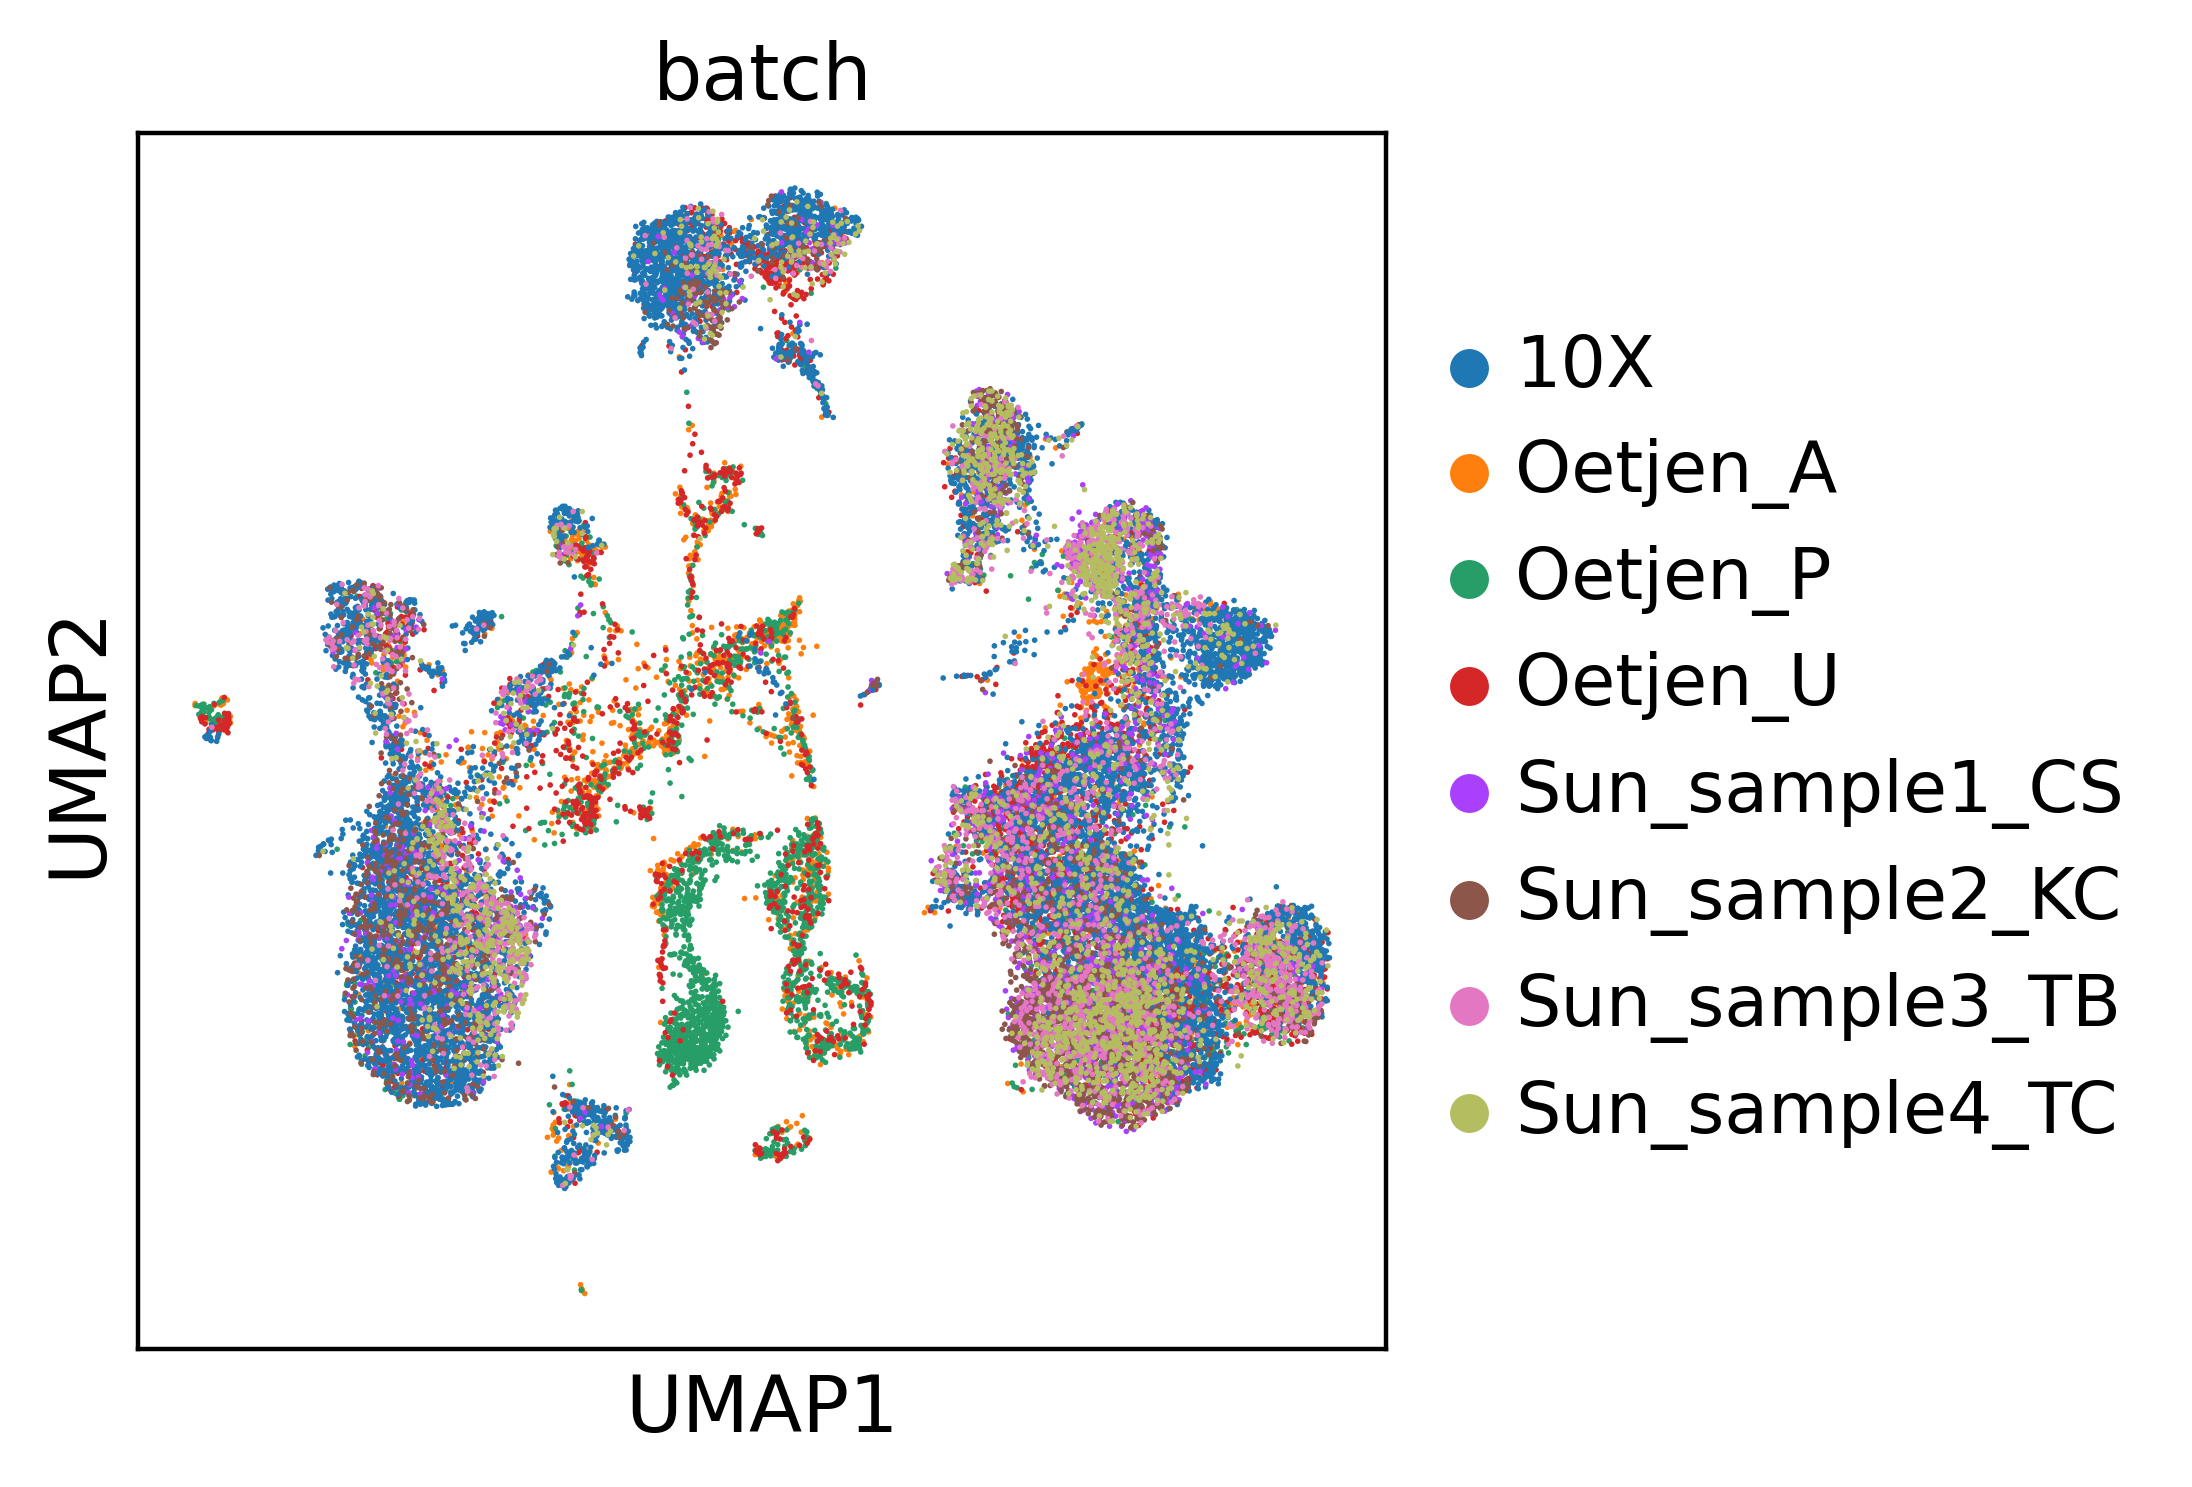

In [9]:
data_latent = tranvae.get_latent(
    labeled_adata.X, 
    labeled_adata.obs[condition_key].values
)
adata_latent_tranvae = sc.AnnData(data_latent)
adata_latent_tranvae.obs['batch'] = labeled_adata.obs[condition_key].tolist()
results_dict = tranvae.classify(
    labeled_adata.X, 
    labeled_adata.obs[condition_key], 
    metric=class_metric
)
print(results_dict)
sc.pp.neighbors(adata_latent_tranvae)
sc.tl.umap(adata_latent_tranvae)
sc.pl.umap(adata_latent_tranvae, color='batch')

In [10]:
embed.train(
    n_epochs=500,
    early_stopping_kwargs=early_stopping_kwargs,
    pretraining_epochs=100,
    alpha_epoch_anneal=alpha_epoch_anneal,
    eta=eta,
    tau=tau,
    clustering_res=clustering_res,
    labeled_loss_metric=labeled_loss_metric,
    unlabeled_loss_metric=unlabeled_loss_metric
)

 |████----------------| 20.0%  - val_loss: 1311.6862041767 - val_trvae_loss: 1311.6862041767
Initializing unlabeled landmarks with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 40 clusters.
 |██████--------------| 33.8%  - val_loss: 1311.5596078726 - val_trvae_loss: 1310.9857083834 - val_classifier_loss: 0.5738885036 - val_unlabeled_loss: 1.3645204581 - val_labeled_loss: 0.5725239871
ADJUSTED LR
 |████████------------| 41.8%  - val_loss: 1308.3996769832 - val_trvae_loss: 1307.9186166617 - val_classifier_loss: 0.4810476727 - val_unlabeled_loss: 1.1698451271 - val_labeled_loss: 0.4798778296
ADJUSTED LR
 |████████------------| 43.2%  - val_loss: 1308.5366257888 - val_trvae_loss: 1308.0538940430 - val_classifier_loss: 0.4827413112 - val_unlabeled_loss: 1.1482247802 - val_labeled_loss: 0.4815930839
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different para

[{'preds': array(['CD16+ Monocytes', 'CD4+ T cells', 'CD14+ Monocytes',
       'CD14+ Monocytes', 'NKT cells', 'CD14+ Monocytes',
       'CD14+ Monocytes', ..., 'NKT cells', 'NK cells', 'CD14+ Monocytes',
       'CD14+ Monocytes', 'NK cells', 'NK cells', 'CD4+ T cells'],
      dtype='<U32'), 'probs': array([0.09, 0.09, 0.08, 0.09, 0.09, 0.08, 0.08, ..., 0.08, 0.09, 0.08,
       0.09, 0.09, 0.08, 0.09], dtype=float32)}]


... storing 'batch' as categorical


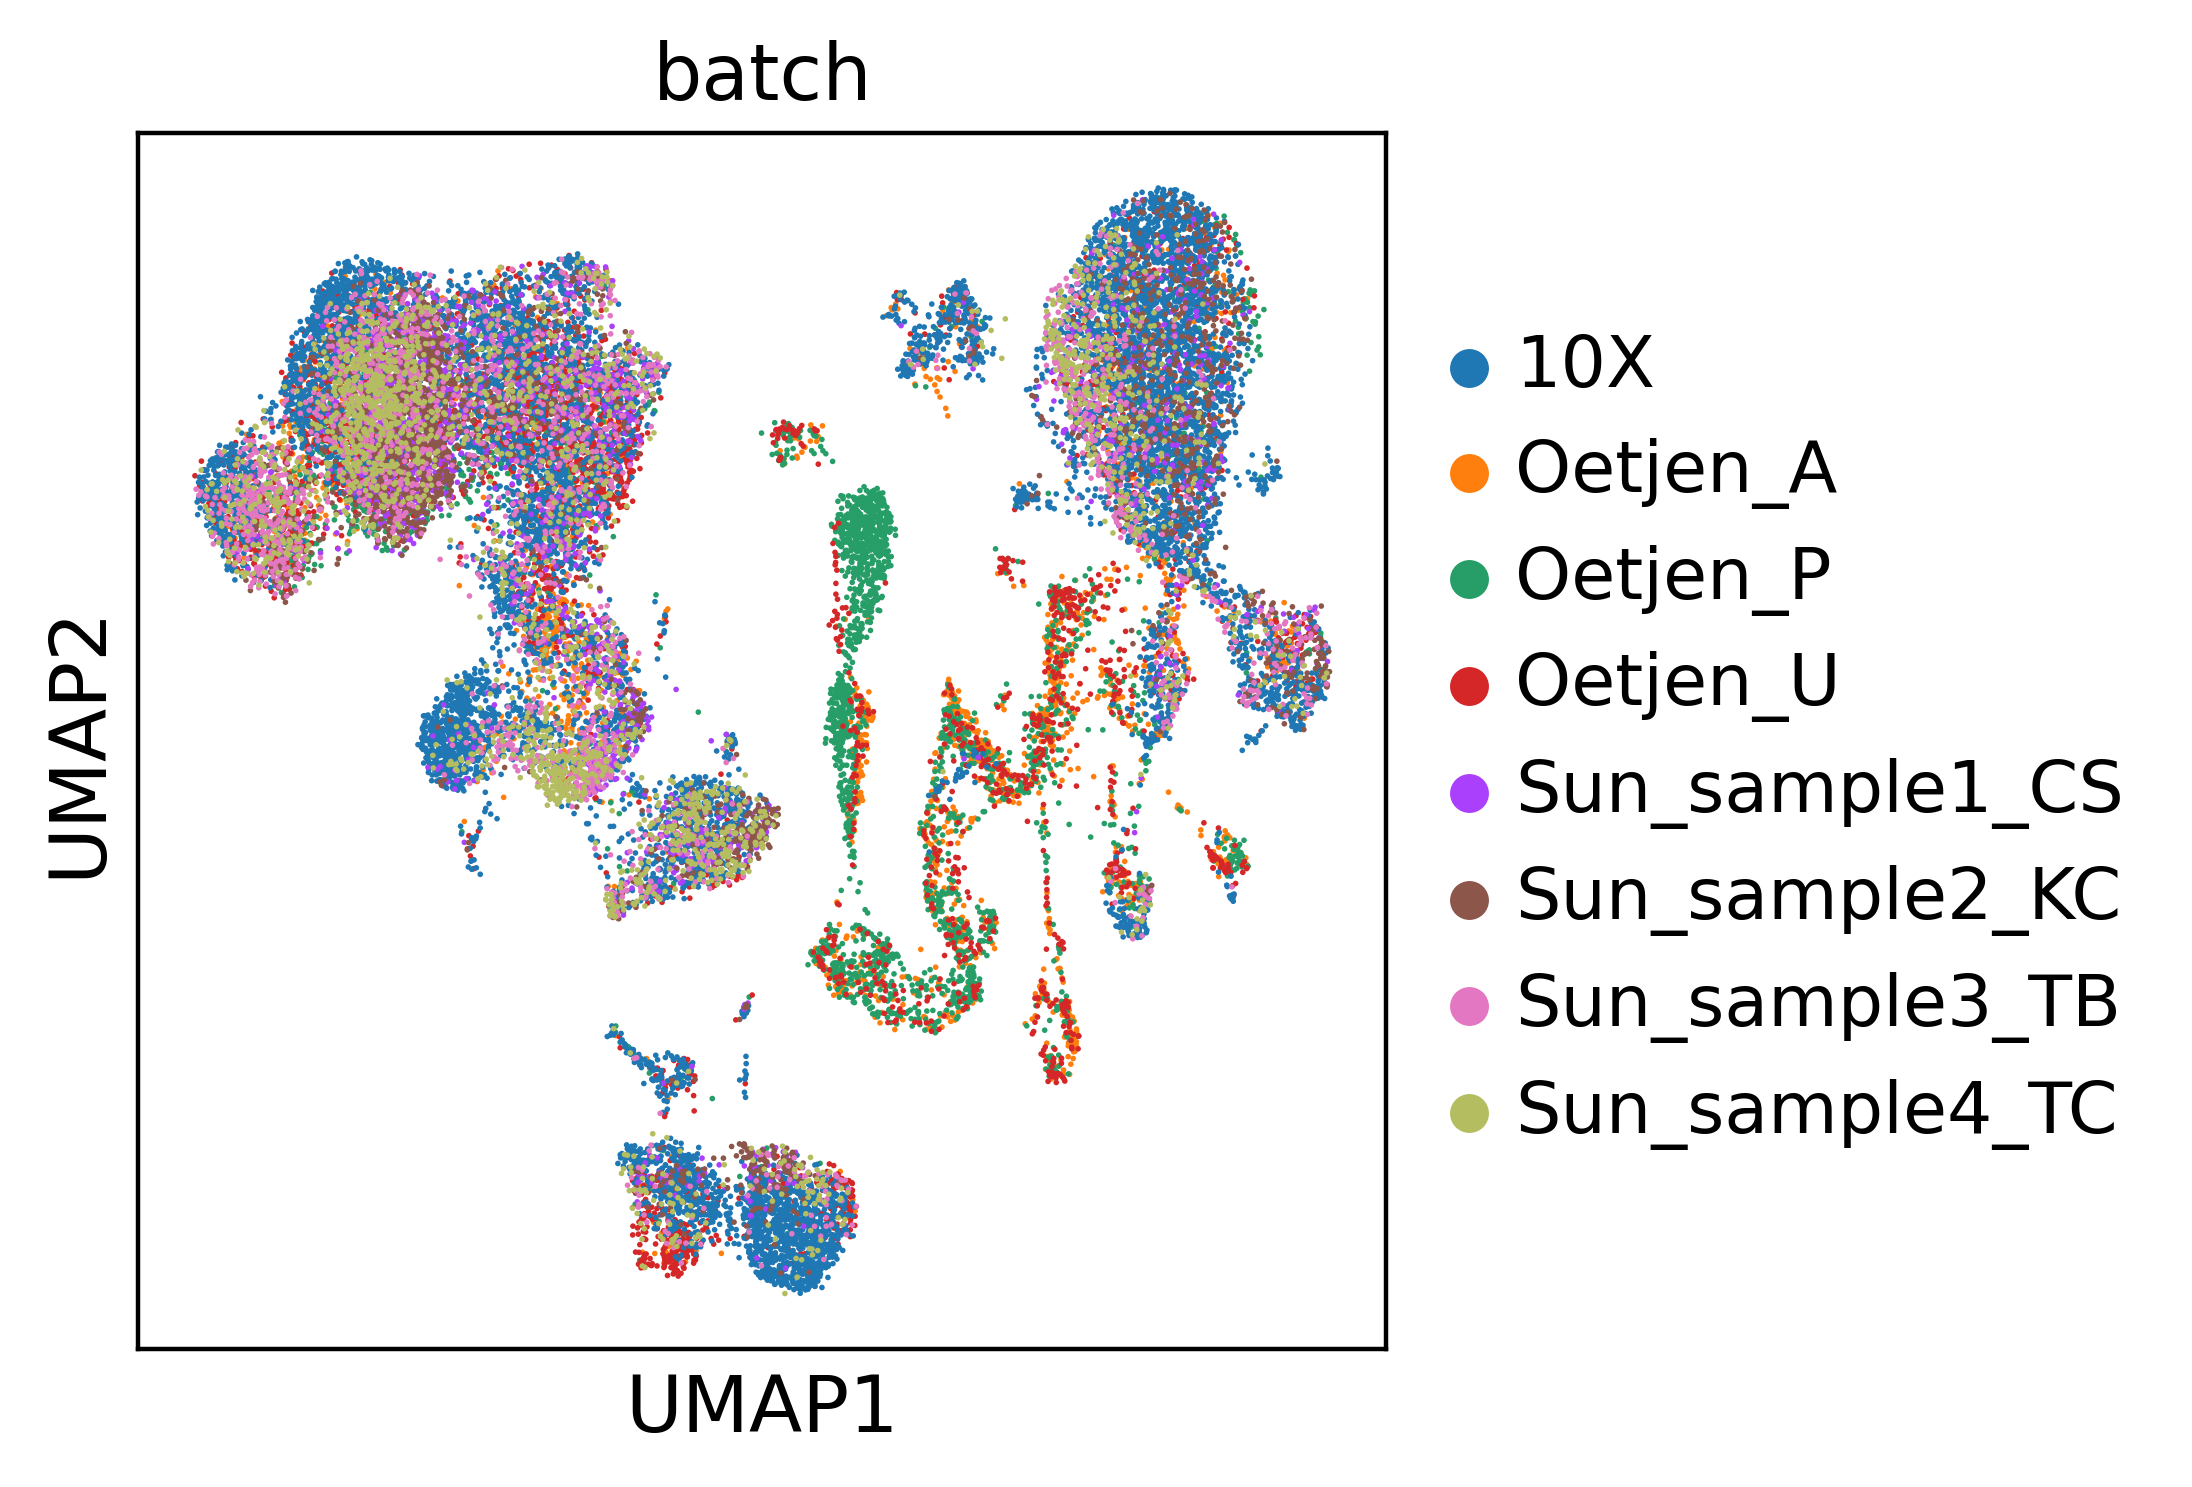

In [11]:
data_latent = embed.get_latent(
    labeled_adata.X, 
    labeled_adata.obs[condition_key].values
)
adata_latent_embed = sc.AnnData(data_latent)
adata_latent_embed.obs['batch'] = labeled_adata.obs[condition_key].tolist()
results_dict_embed = embed.classify(
    labeled_adata.X, 
    labeled_adata.obs[condition_key], 
    metric=class_metric
)
print(results_dict_embed)
sc.pp.neighbors(adata_latent_embed)
sc.tl.umap(adata_latent_embed)
sc.pl.umap(adata_latent_embed, color='batch')

In [12]:
embed_dec.train(
    n_epochs=500,
    early_stopping_kwargs=early_stopping_kwargs,
    pretraining_epochs=100,
    alpha_epoch_anneal=alpha_epoch_anneal,
    eta=eta,
    tau=tau,
    clustering_res=clustering_res,
    labeled_loss_metric=labeled_loss_metric,
    unlabeled_loss_metric=unlabeled_loss_metric
)

 |████----------------| 20.0%  - val_loss: 1334.1988149790 - val_trvae_loss: 1334.1988149790
Initializing unlabeled landmarks with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 41 clusters.
 |██████--------------| 32.0%  - val_loss: 1338.8425997221 - val_trvae_loss: 1338.2672635592 - val_classifier_loss: 0.5753369629 - val_unlabeled_loss: 1.4237618997 - val_labeled_loss: 0.5739132005
ADJUSTED LR
 |███████-------------| 38.6%  - val_loss: 1331.4619516226 - val_trvae_loss: 1330.9722947341 - val_classifier_loss: 0.4896416687 - val_unlabeled_loss: 1.2645373344 - val_labeled_loss: 0.4883771378
ADJUSTED LR
 |████████------------| 40.0%  - val_loss: 1334.0726740910 - val_trvae_loss: 1333.6022949219 - val_classifier_loss: 0.4703782648 - val_unlabeled_loss: 1.2152309188 - val_labeled_loss: 0.4691630327
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different para

[{'preds': array(['CD16+ Monocytes', 'CD4+ T cells', 'CD14+ Monocytes',
       'CD14+ Monocytes', 'NKT cells', 'CD14+ Monocytes',
       'CD14+ Monocytes', ..., 'NKT cells', 'NK cells', 'CD14+ Monocytes',
       'CD14+ Monocytes', 'NK cells', 'NK cells', 'CD4+ T cells'],
      dtype='<U32'), 'probs': array([0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.08, ..., 0.09, 0.09, 0.09,
       0.09, 0.09, 0.09, 0.09], dtype=float32)}]


... storing 'batch' as categorical


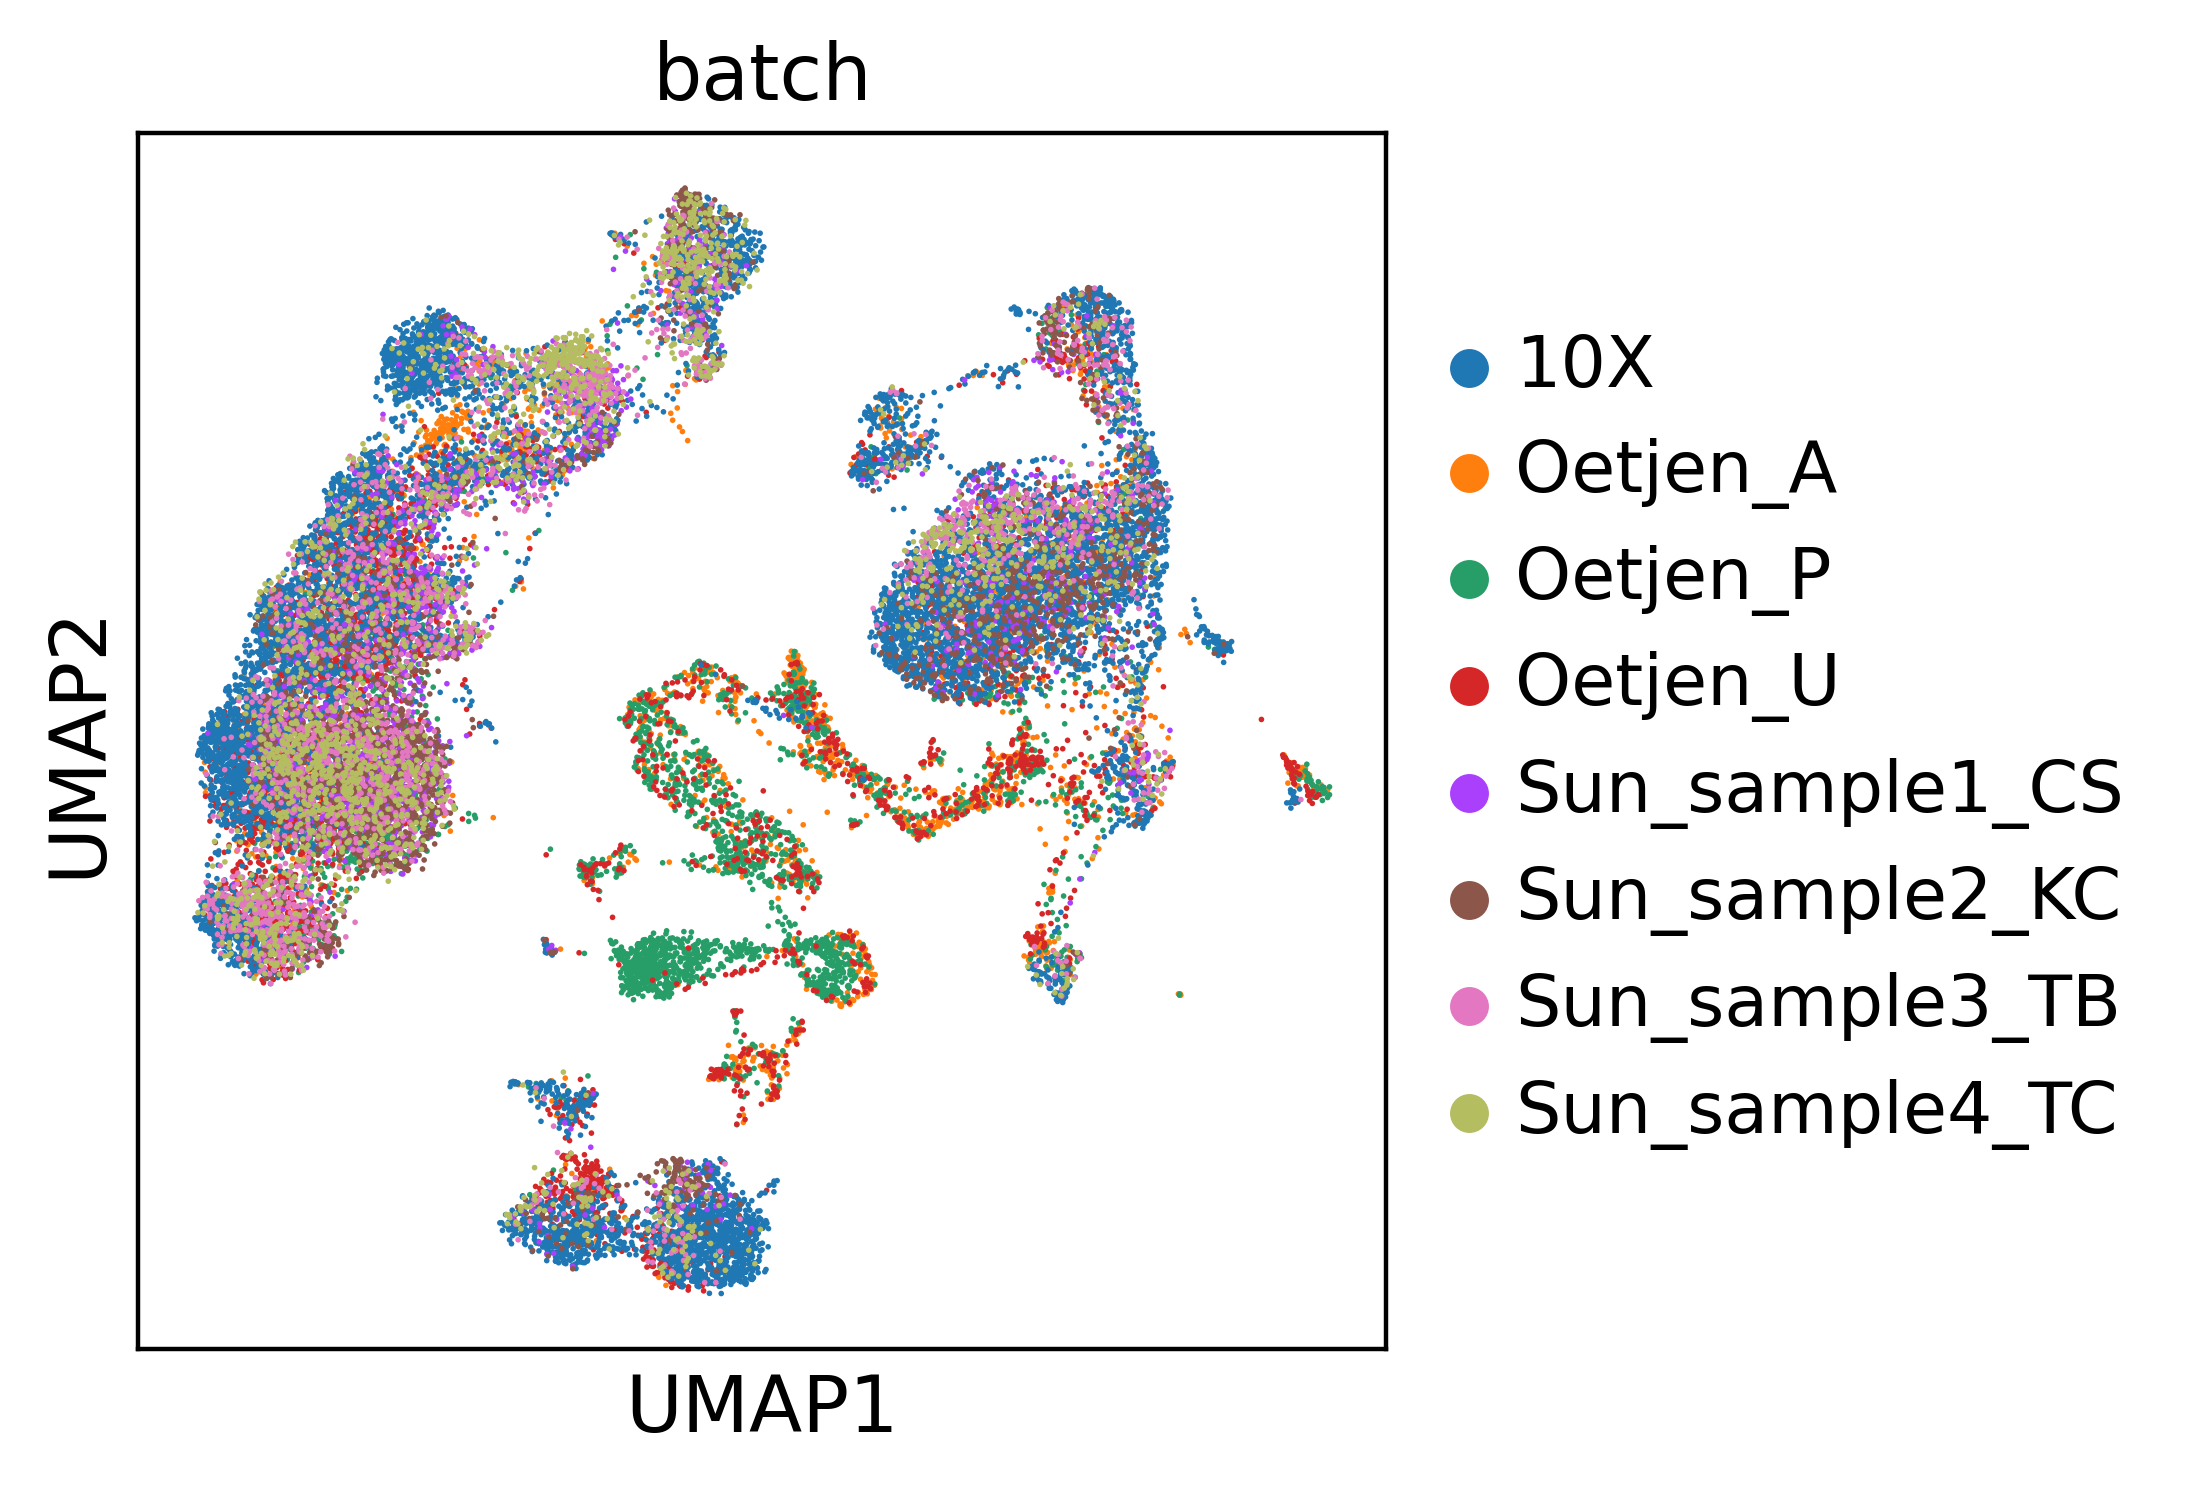

In [13]:
data_latent = embed_dec.get_latent(
    labeled_adata.X, 
    labeled_adata.obs[condition_key].values
)
adata_latent_embed_dec = sc.AnnData(data_latent)
adata_latent_embed_dec.obs['batch'] = labeled_adata.obs[condition_key].tolist()
results_dict_embed_dec = embed_dec.classify(
    labeled_adata.X, 
    labeled_adata.obs[condition_key], 
    metric=class_metric
)
print(results_dict_embed_dec)
sc.pp.neighbors(adata_latent_embed_dec)
sc.tl.umap(adata_latent_embed_dec)
sc.pl.umap(adata_latent_embed_dec, color='batch')

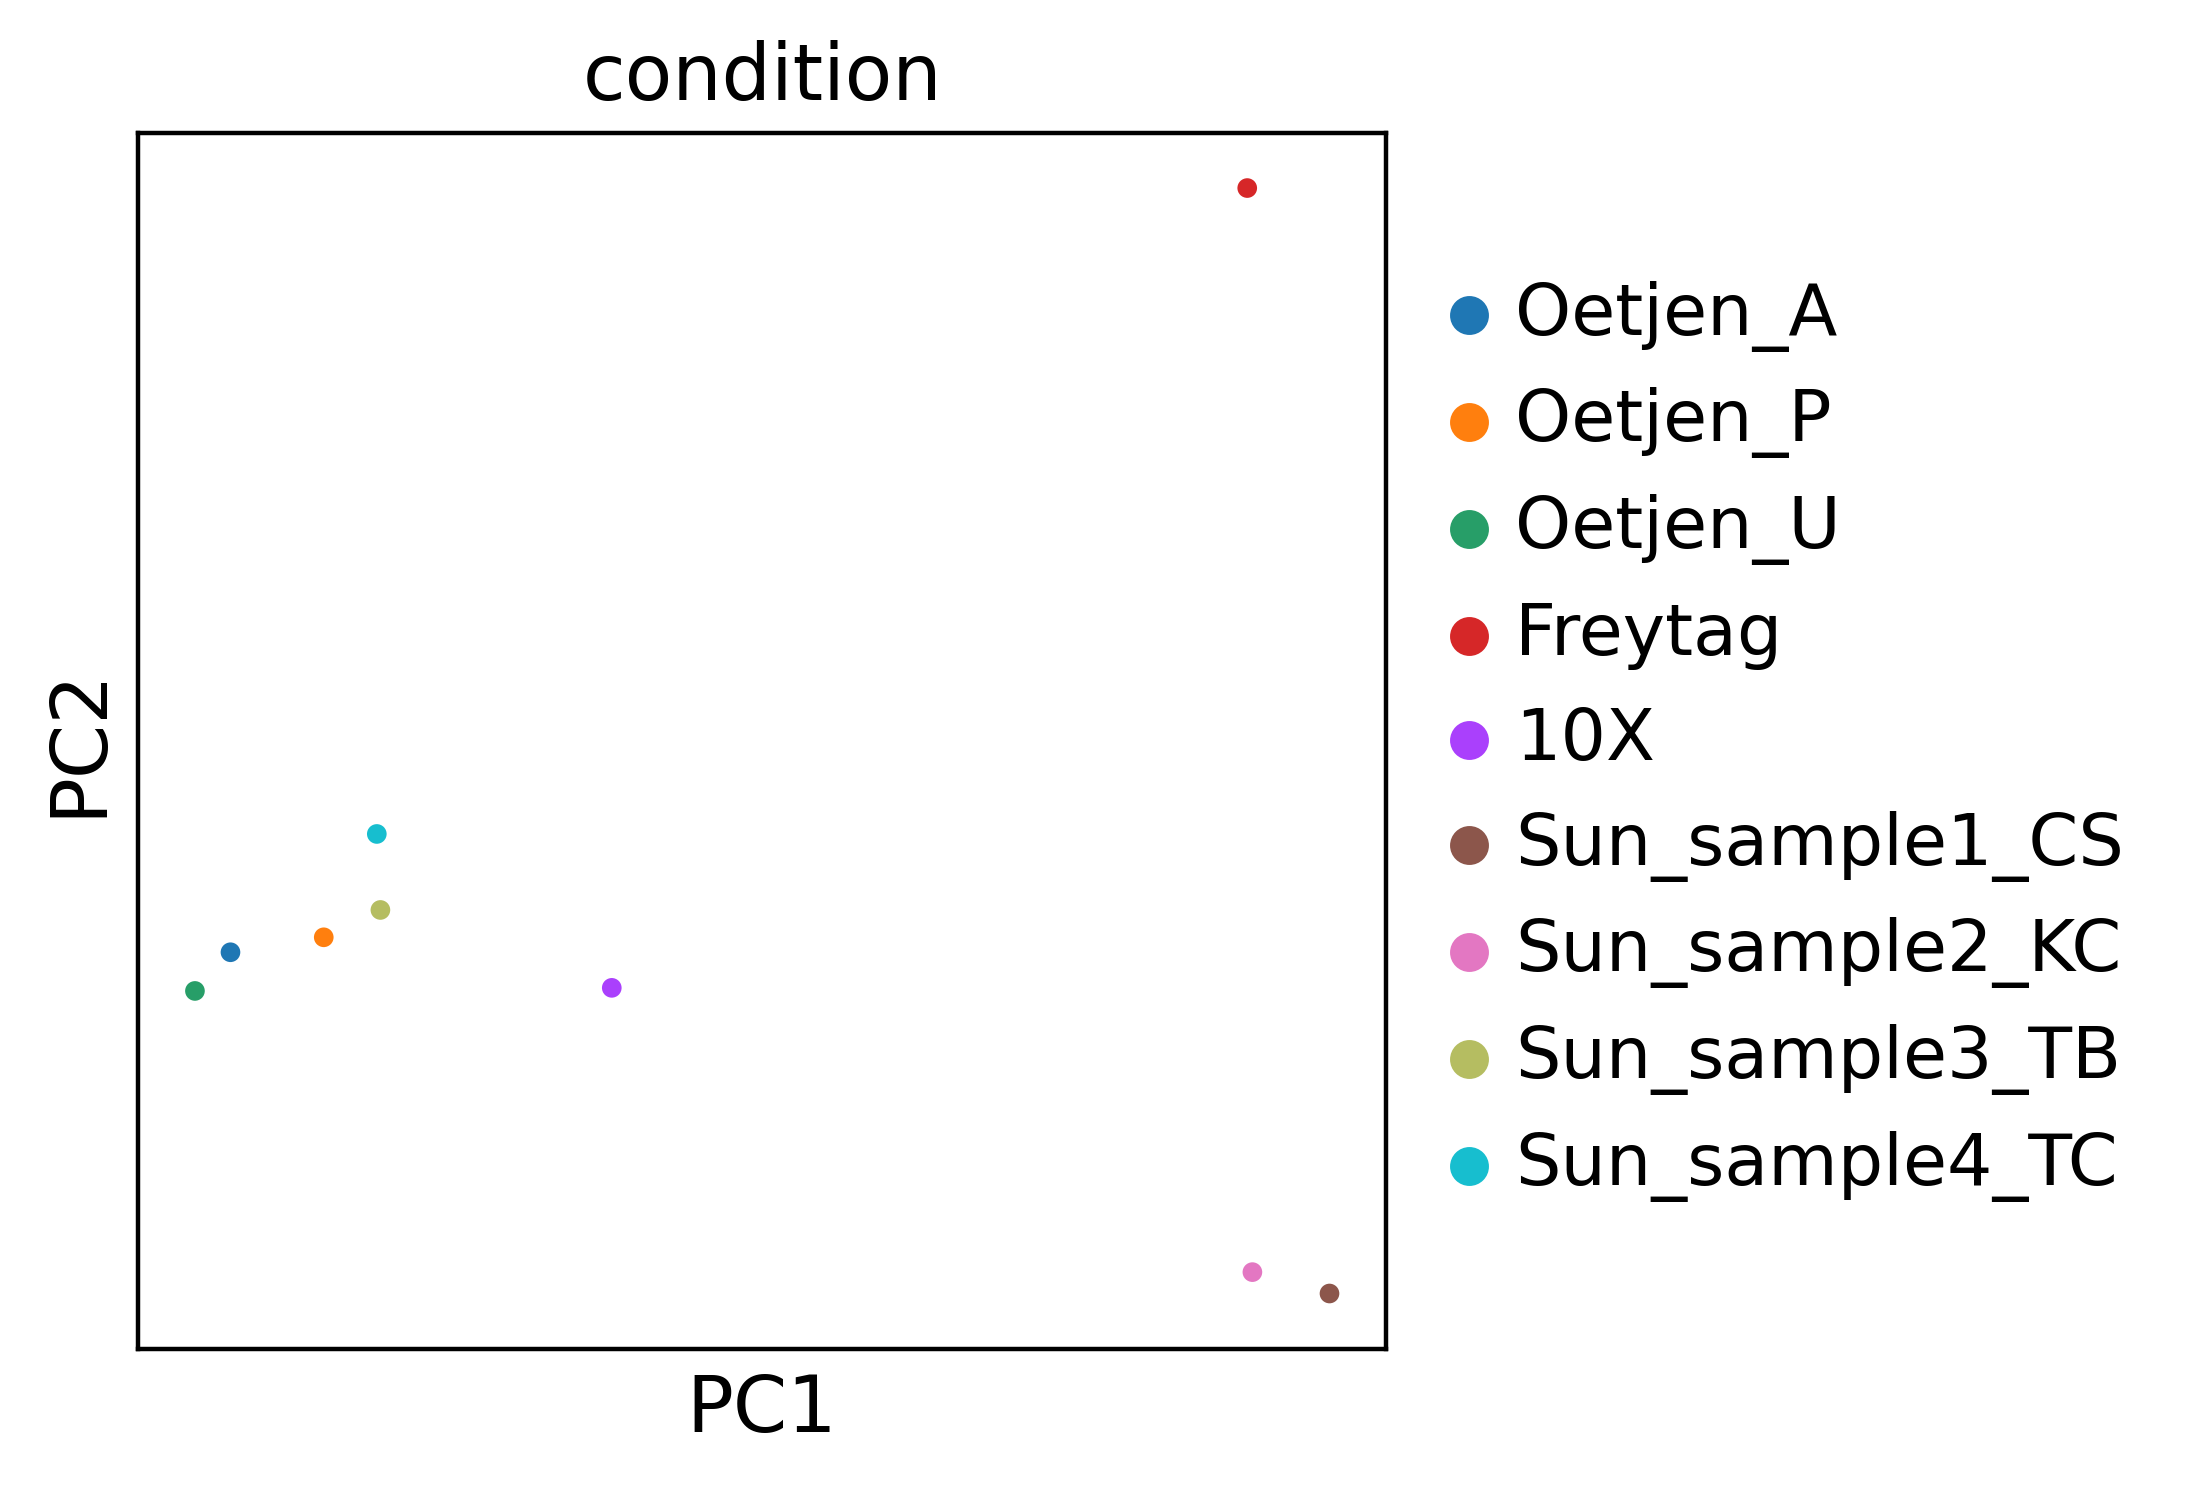

In [36]:
embedding = embed.model.embedding.weight.detach().cpu().numpy()
embedding_adata = sc.AnnData(embedding)
sc.pp.pca(embedding_adata)
embedding_adata.obs['condition'] = adata.obs['condition'].unique()
sc.pl.pca(embedding_adata, size=50, color='condition')

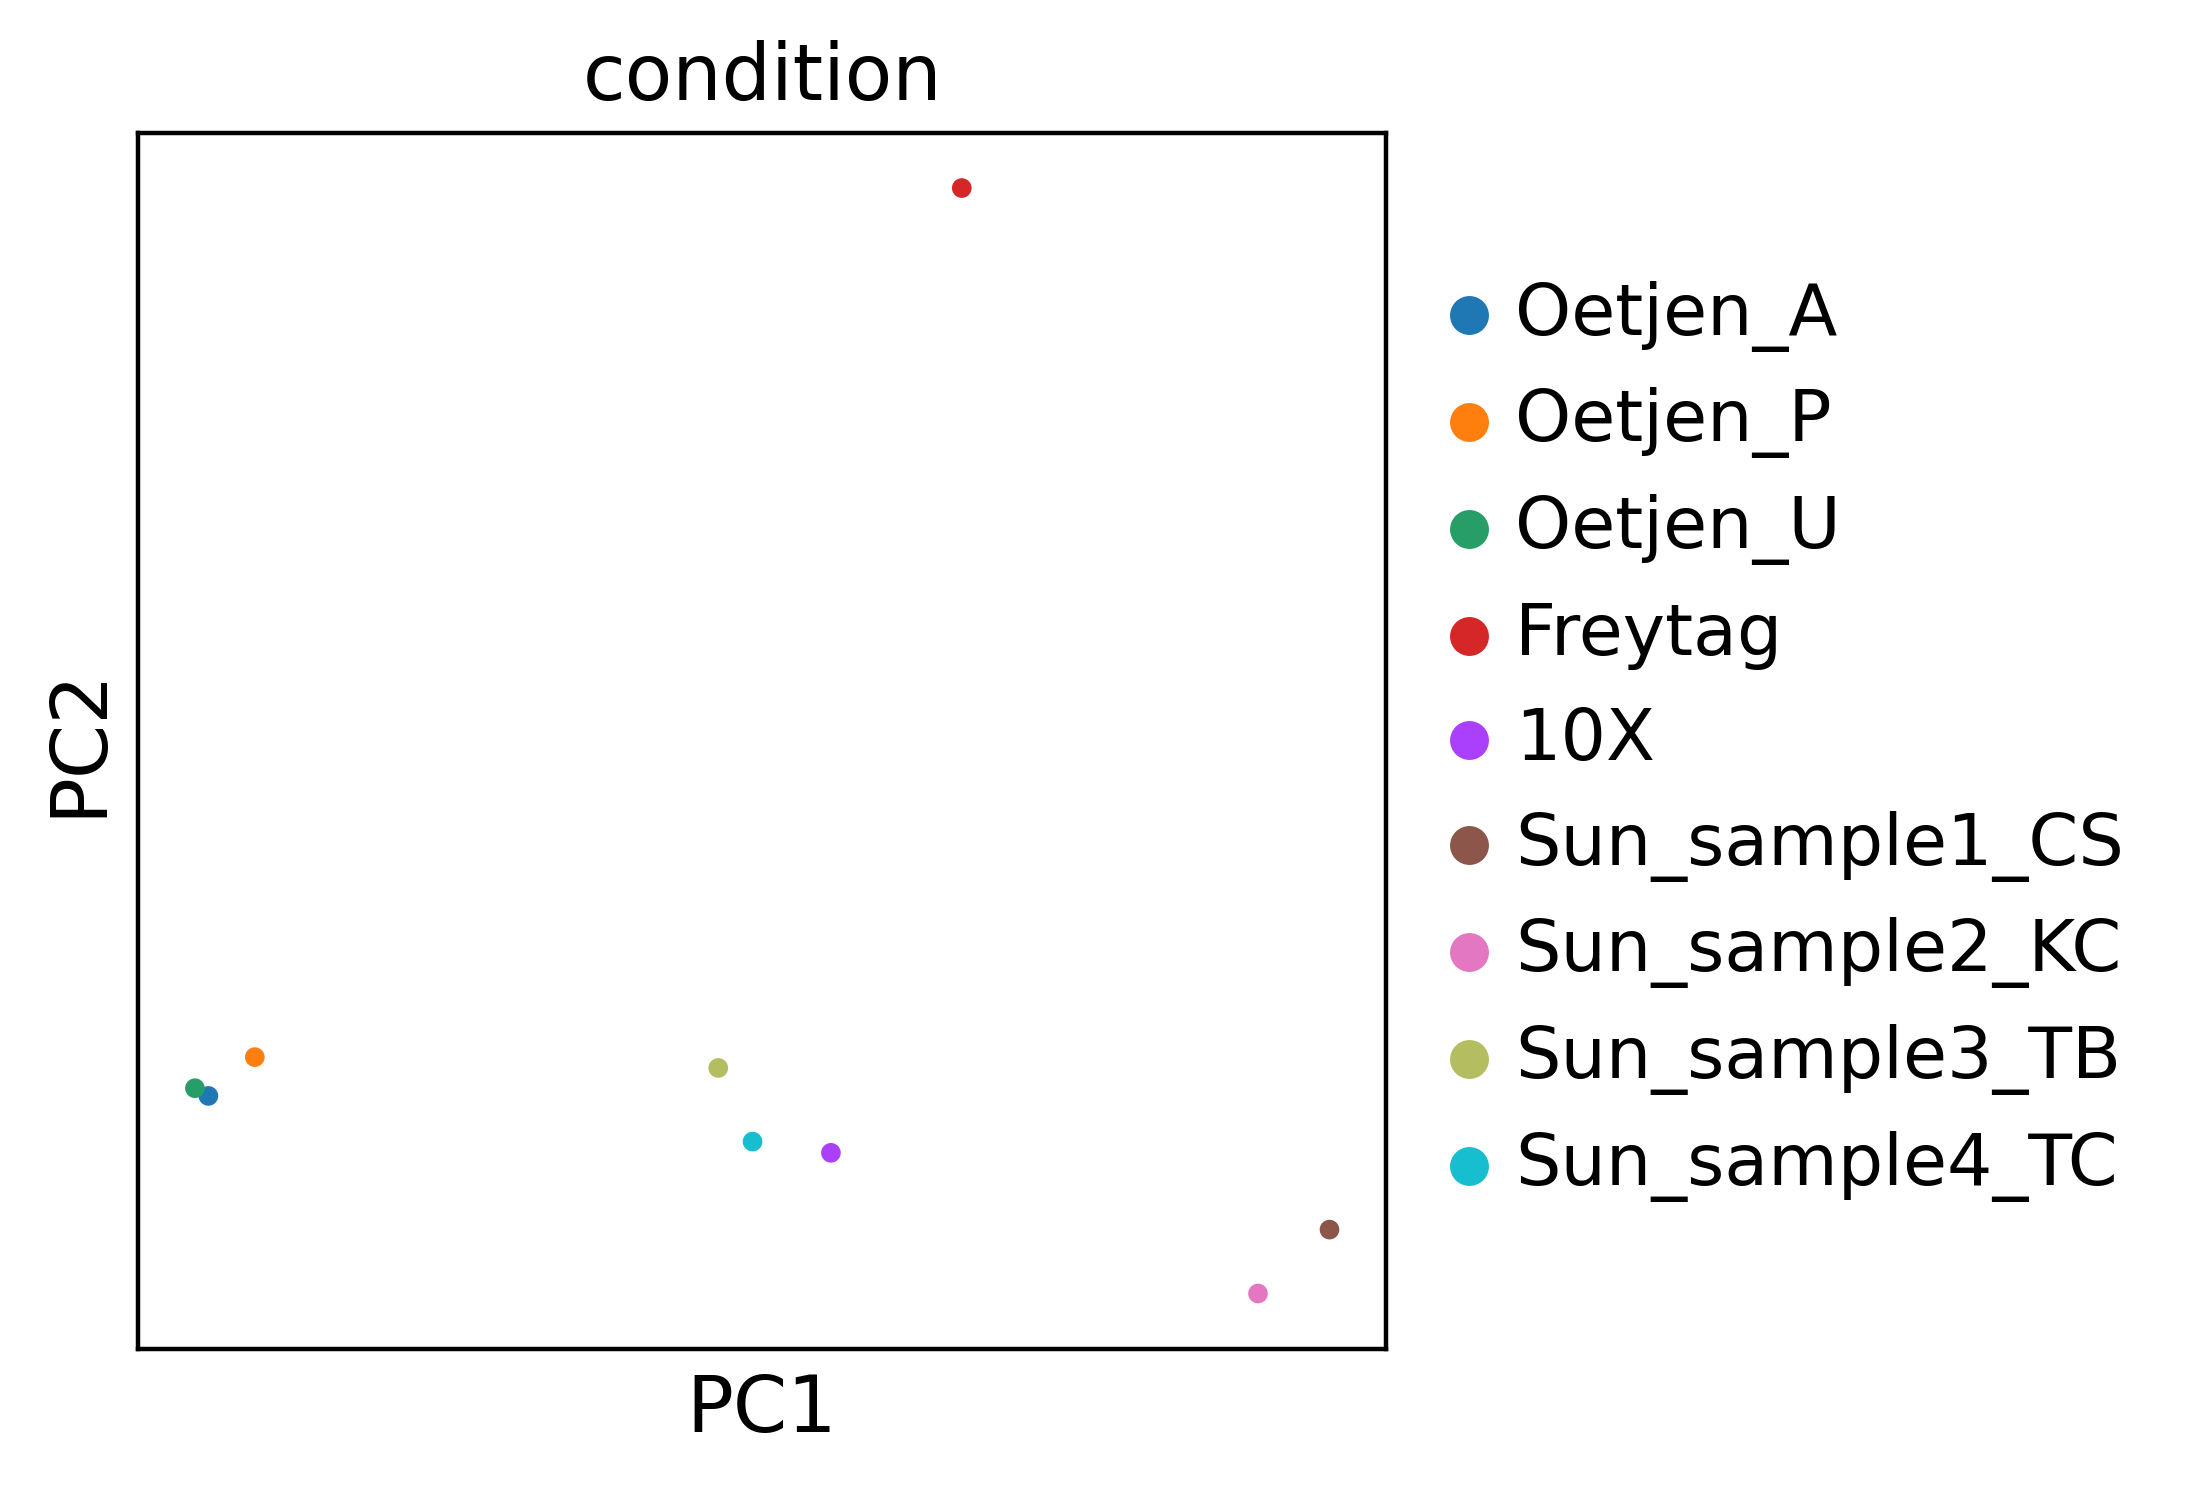

In [37]:
embedding_dec = embed_dec.model.embedding.weight.detach().cpu().numpy()
embedding_dec_adata = sc.AnnData(embedding_dec)
sc.pp.pca(embedding_dec_adata)
embedding_dec_adata.obs['condition'] = adata.obs['condition'].unique()
sc.pl.pca(embedding_dec_adata, size=50, color='condition')

In [38]:
embed_ctrl = EMBEDCVAE(
    adata=adata,
    condition_key=condition_key,
    inject_condition = [],
    embedding_dim = 10,
    cell_type_keys=cell_type_key,
    hidden_layer_sizes=[128, 128],
    latent_dim=latent_dim,
    use_mmd=use_mmd,
    labeled_indices=labeled_ind,
    unknown_ct_names=None
)

Encoder Architecture:
	Input Layer in, out and cond: 4000 128 0
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 0
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4000 



In [39]:
embed_ctrl.train(
    n_epochs=500,
    early_stopping_kwargs=early_stopping_kwargs,
    pretraining_epochs=100,
    alpha_epoch_anneal=alpha_epoch_anneal,
    eta=eta,
    tau=tau,
    clustering_res=clustering_res,
    labeled_loss_metric=labeled_loss_metric,
    unlabeled_loss_metric=unlabeled_loss_metric
)

 |████----------------| 20.0%  - val_loss: 1322.6593111478 - val_trvae_loss: 1322.6593111478
Initializing unlabeled landmarks with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 50 clusters.
 |████████------------| 42.6%  - val_loss: 1318.9431199294 - val_trvae_loss: 1318.1995051457 - val_classifier_loss: 0.7436115558 - val_unlabeled_loss: 14.5481937482 - val_labeled_loss: 0.72906336197
ADJUSTED LR
 |██████████----------| 52.0%  - val_loss: 1315.6829317533 - val_trvae_loss: 1315.1000413161 - val_classifier_loss: 0.5828748724 - val_unlabeled_loss: 12.8617657882 - val_labeled_loss: 0.5700131116
ADJUSTED LR
 |██████████----------| 53.4%  - val_loss: 1315.9248187725 - val_trvae_loss: 1315.3553325947 - val_classifier_loss: 0.5694736873 - val_unlabeled_loss: 12.7701161458 - val_labeled_loss: 0.5567035687
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different 

[{'preds': array(['CD16+ Monocytes', 'CD4+ T cells', 'CD14+ Monocytes',
       'CD14+ Monocytes', 'NKT cells', 'CD14+ Monocytes',
       'CD14+ Monocytes', ..., 'NKT cells', 'NK cells', 'CD14+ Monocytes',
       'CD14+ Monocytes', 'NK cells', 'NK cells', 'CD4+ T cells'],
      dtype='<U32'), 'probs': array([0.1 , 0.1 , 0.09, 0.08, 0.09, 0.09, 0.08, ..., 0.1 , 0.1 , 0.11,
       0.11, 0.09, 0.1 , 0.11], dtype=float32)}]


... storing 'batch' as categorical


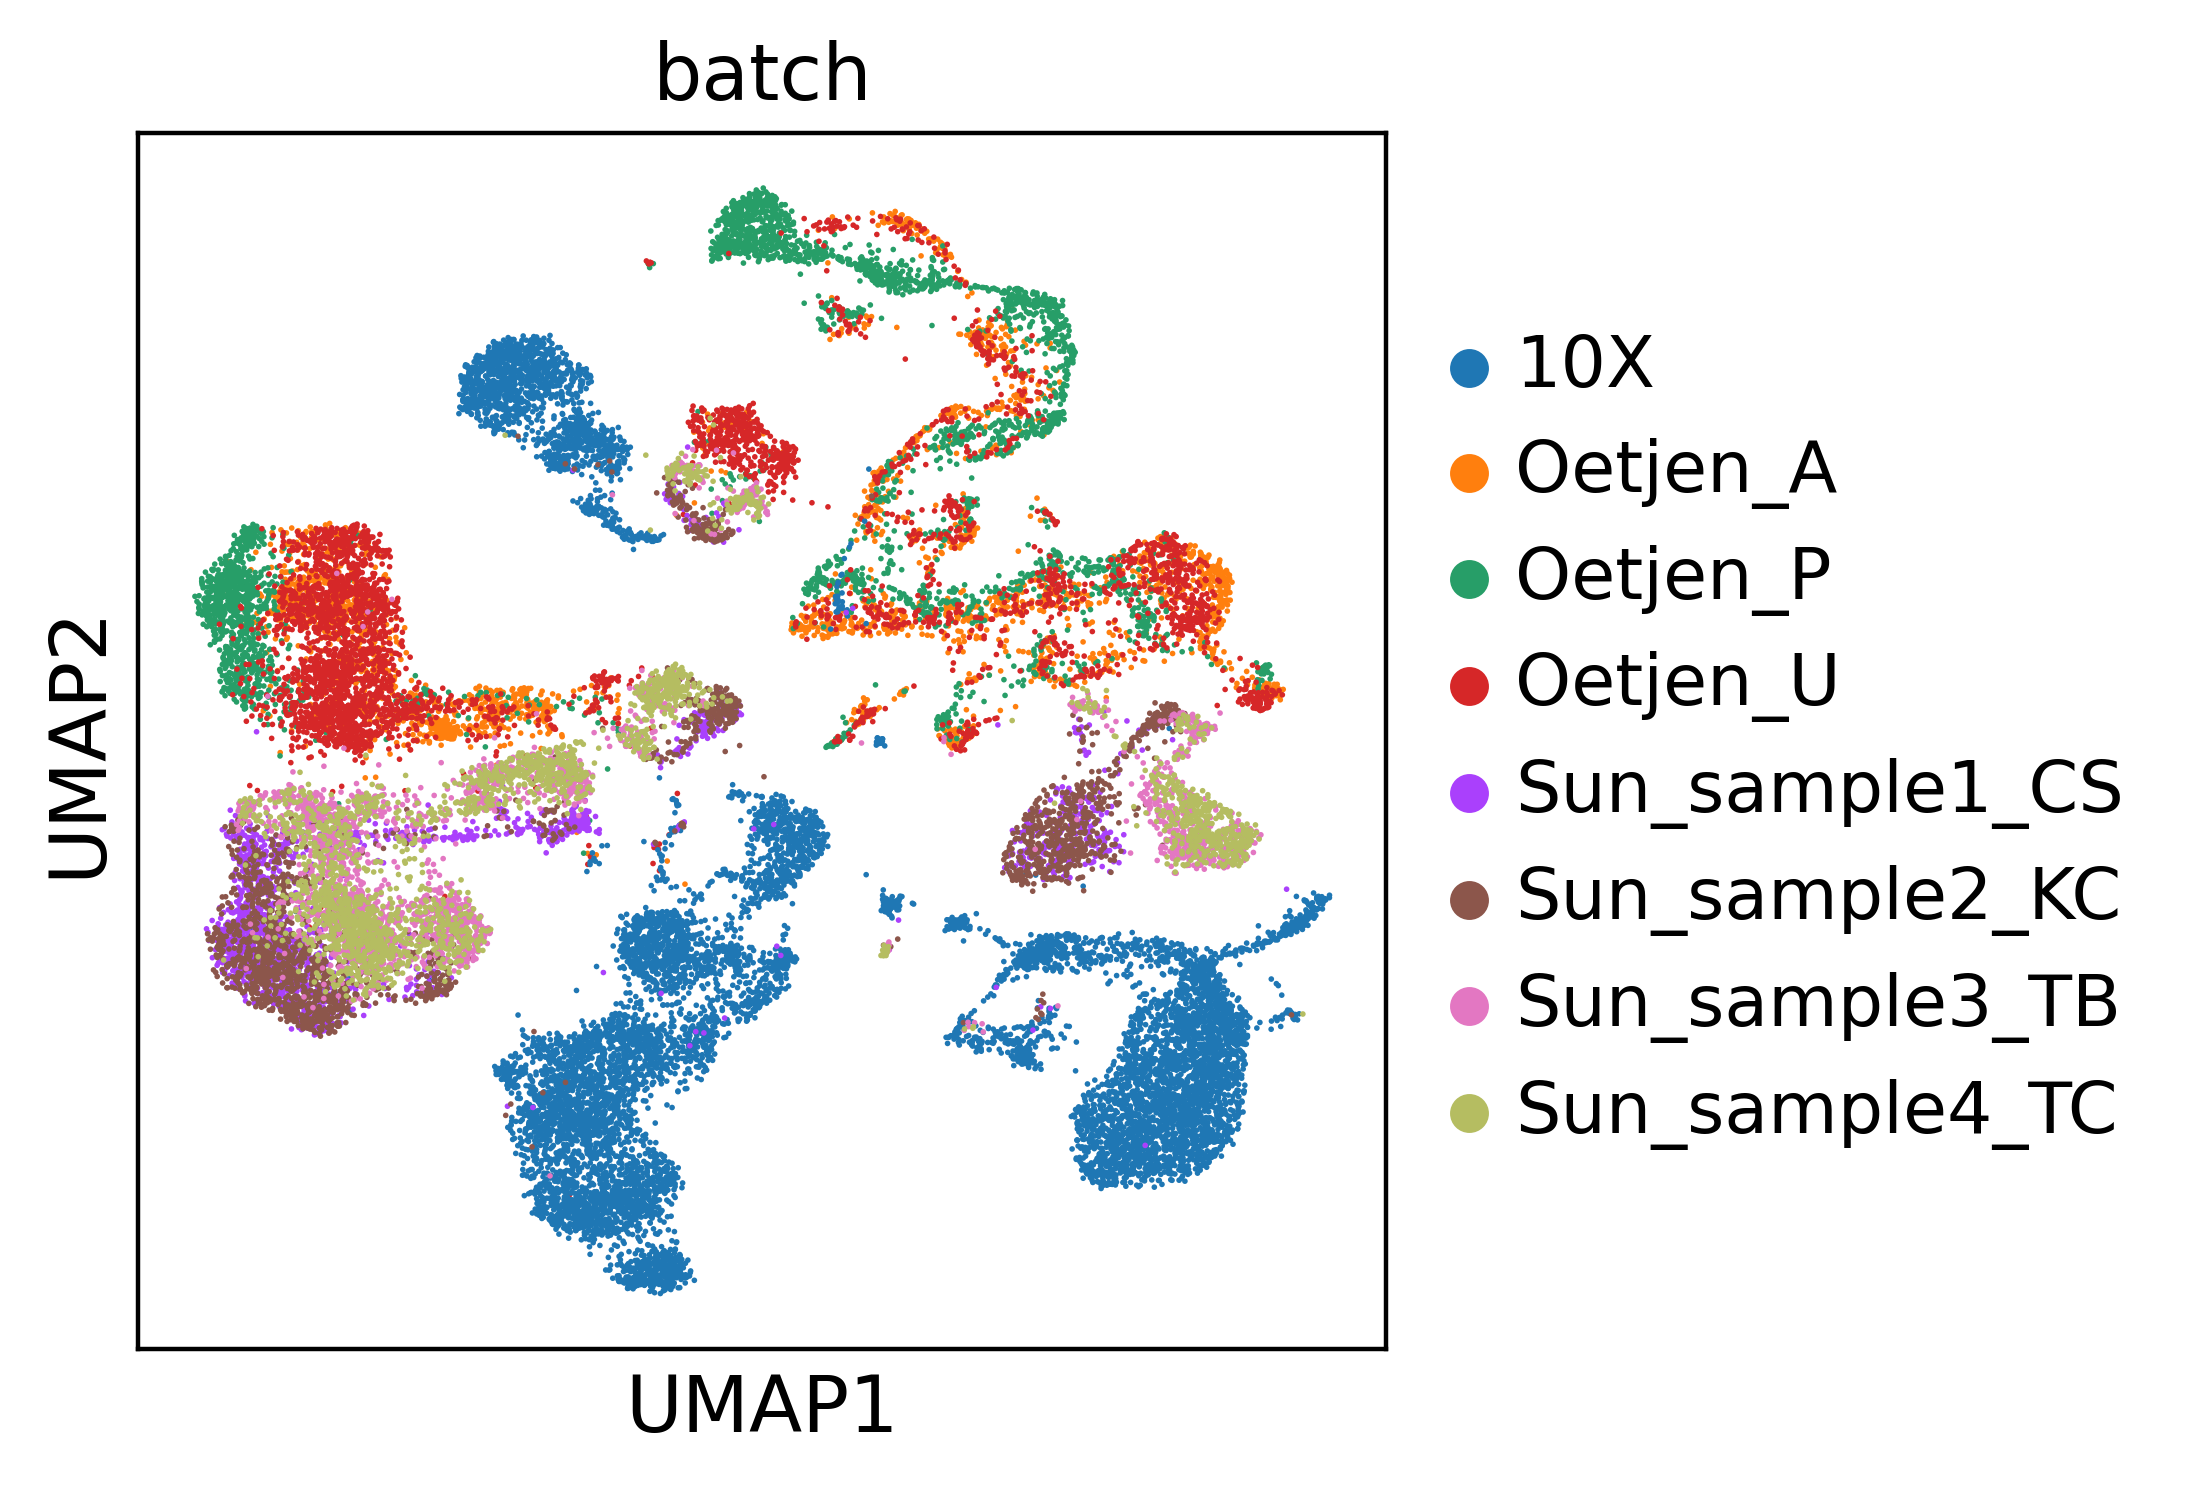

In [40]:
data_latent = embed_ctrl.get_latent(
    labeled_adata.X, 
    labeled_adata.obs[condition_key].values
)
adata_latent_embed_ctrl = sc.AnnData(data_latent)
adata_latent_embed_ctrl.obs['batch'] = labeled_adata.obs[condition_key].tolist()
results_dict_embed_ctrl = embed_ctrl.classify(
    labeled_adata.X, 
    labeled_adata.obs[condition_key], 
    metric=class_metric
)
print(results_dict_embed_ctrl)
sc.pp.neighbors(adata_latent_embed_ctrl)
sc.tl.umap(adata_latent_embed_ctrl)
sc.pl.umap(adata_latent_embed_ctrl, color='batch')

In [42]:
embed_dec.save('../tranvae_benchmarks/embed.tar', overwrite=True)

In [52]:
embed_dec_query.model

EmbedCVAE(
  (embedding): Embedding(9, 10)
  (encoder): Encoder(
    (FC): Sequential(
      (L0): CondLayers(
        (expr_L): Linear(in_features=4000, out_features=128, bias=True)
      )
      (N0): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
      (A0): ReLU()
      (L1): Linear(in_features=128, out_features=128, bias=True)
      (N1): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
      (A1): ReLU()
    )
    (mean_encoder): Linear(in_features=128, out_features=10, bias=True)
    (log_var_encoder): Linear(in_features=128, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (FirstL): Sequential(
      (L0): CondLayers(
        (expr_L): Linear(in_features=10, out_features=128, bias=False)
        (cond_L): Linear(in_features=10, out_features=128, bias=False)
      )
      (N0): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
      (A0): ReLU()
    )
    (HiddenL): Sequential(
      (L1): Linear(in_features=128, out_features=128, bias=False)
      (N

In [80]:
DATA_DIR = '../data'
adata = sc.read(
    f'{DATA_DIR}/benchmark_pbmc_shrinked.h5ad'
)
condition_key = 'condition'
reference = ['Oetjen', '10X', 'Sun']
query = ['Freytag']
adata_ref = adata[adata.obs['study'].isin(reference)]
adata_query = adata[adata.obs['study'].isin(query)]

In [111]:
embed_surg = EMBEDCVAE(
    adata=adata_ref,
    condition_key=condition_key,
    inject_condition = ['decoder'],
    embedding_dim = 10,
    recon_loss = 'mse',
    cell_type_keys=cell_type_key,
    hidden_layer_sizes=[128, 128],
    latent_dim=latent_dim,
    unknown_ct_names=None
)

Embedding dictionary:
 	Num conditions: 8
 	Embedding dim: 10
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 0
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 10
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4000 



In [112]:
embed_surg.train(
    n_epochs=500,
    early_stopping_kwargs=early_stopping_kwargs,
    pretraining_epochs=100,
    alpha_epoch_anneal=alpha_epoch_anneal,
    eta=eta,
    tau=tau,
    clustering_res=clustering_res,
    labeled_loss_metric=labeled_loss_metric,
    unlabeled_loss_metric=unlabeled_loss_metric
)

 |███████-------------| 38.0%  - val_loss: 8662.4793435802 - val_trvae_loss: 8642.0365574049 - val_classifier_loss: 20.4428709279 - val_labeled_loss: 20.44287092798376
ADJUSTED LR
 |███████████---------| 58.0%  - val_loss: 8127.5717030401 - val_trvae_loss: 8114.6985924762 - val_classifier_loss: 12.8731314203 - val_labeled_loss: 12.8731314203
ADJUSTED LR
 |████████████--------| 63.6%  - val_loss: 8056.1387037194 - val_trvae_loss: 8043.7608377208 - val_classifier_loss: 12.3778624535 - val_labeled_loss: 12.3778624535
ADJUSTED LR
 |█████████████-------| 66.4%  - val_loss: 8114.2530252208 - val_trvae_loss: 8101.7526537024 - val_classifier_loss: 12.5004416756 - val_labeled_loss: 12.5004416756
ADJUSTED LR
 |█████████████-------| 67.8%  - val_loss: 8109.0414083730 - val_trvae_loss: 8096.4207498302 - val_classifier_loss: 12.6206732626 - val_labeled_loss: 12.6206732626
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiat

In [114]:
embed_surg.model.embedding

Embedding(8, 10)

In [116]:
embedding_dec_adata.obs

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7]

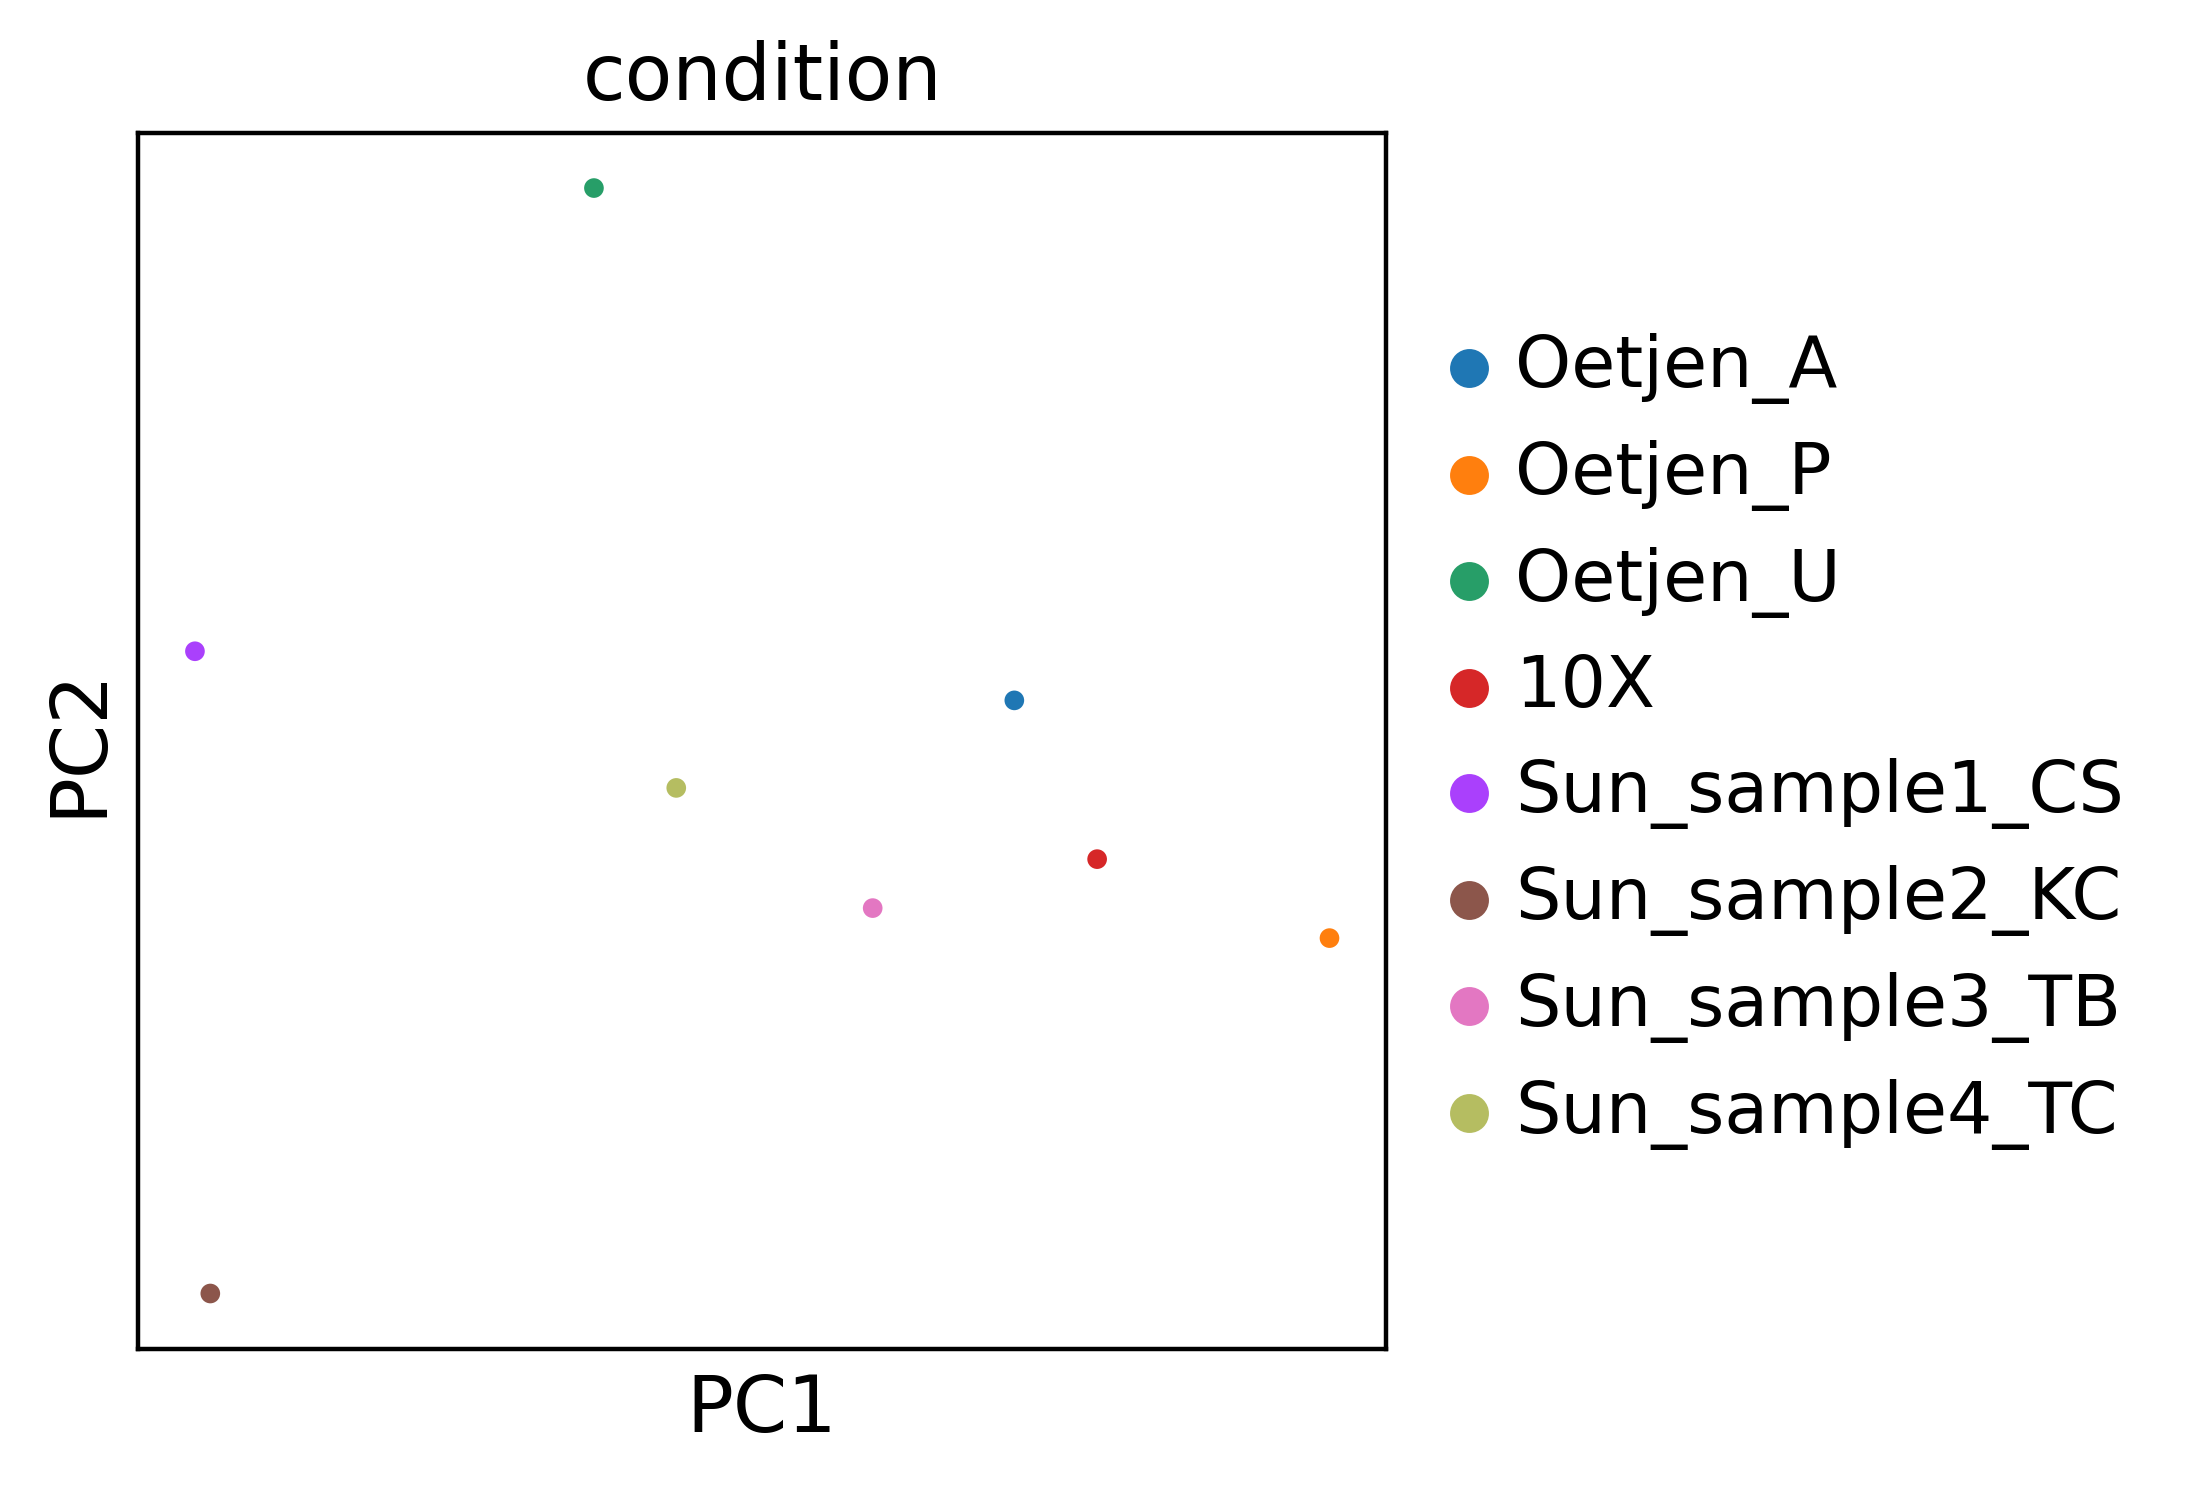

In [117]:
embedding_dec = embed_surg.model.embedding.weight.detach().cpu().numpy()
embedding_dec_adata = sc.AnnData(embedding_dec)
sc.pp.pca(embedding_dec_adata)
embedding_dec_adata.obs['condition'] = adata_ref.obs['condition'].unique()
sc.pl.pca(embedding_dec_adata, size=50, color='condition')

In [118]:
embed_surg.save('./../tranvae_benchmarks/embed.tar', overwrite=True)

In [119]:
embed_dec_query = EMBEDCVAE.load_query_data(
    adata=adata_query,
    reference_model=f'../tranvae_benchmarks/embed.tar',
    labeled_indices=[],
)
embed_dec_query.train(
    n_epochs=500,
    early_stopping_kwargs=early_stopping_kwargs,
    pretraining_epochs=100,
    eta=eta,
    tau=tau,
    weight_decay=0,
    clustering_res=clustering_res,
    labeled_loss_metric=labeled_loss_metric,
    unlabeled_loss_metric=unlabeled_loss_metric
)

AnnData object with n_obs × n_vars = 3347 × 4000
    obs: 'study', 'condition', 'cell_type', 'trvae_size_factors', 'trvae_labeled'
Embedding dictionary:
 	Num conditions: 9
 	Embedding dim: 10
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 0
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 10
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4000 

 |████----------------| 20.0%  - val_loss: 571.8888244629 - val_trvae_loss: 571.8888244629
Initializing unlabeled landmarks with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 25 clusters.
 |█████---------------| 27.0%  - val_loss: 562.9374389648 - val_trvae_loss: 562.9350992839 - val_classifier_loss: 0.0023437086 - val_unlabeled_loss: 2.3437085946
ADJUSTED LR
 |█████---------------| 28.4%  - val_loss: 559.9725545247 - val_trvae_loss: 559.9701334635 - val_classifier_loss: 0.0024208537 - val_unlabeled_lo

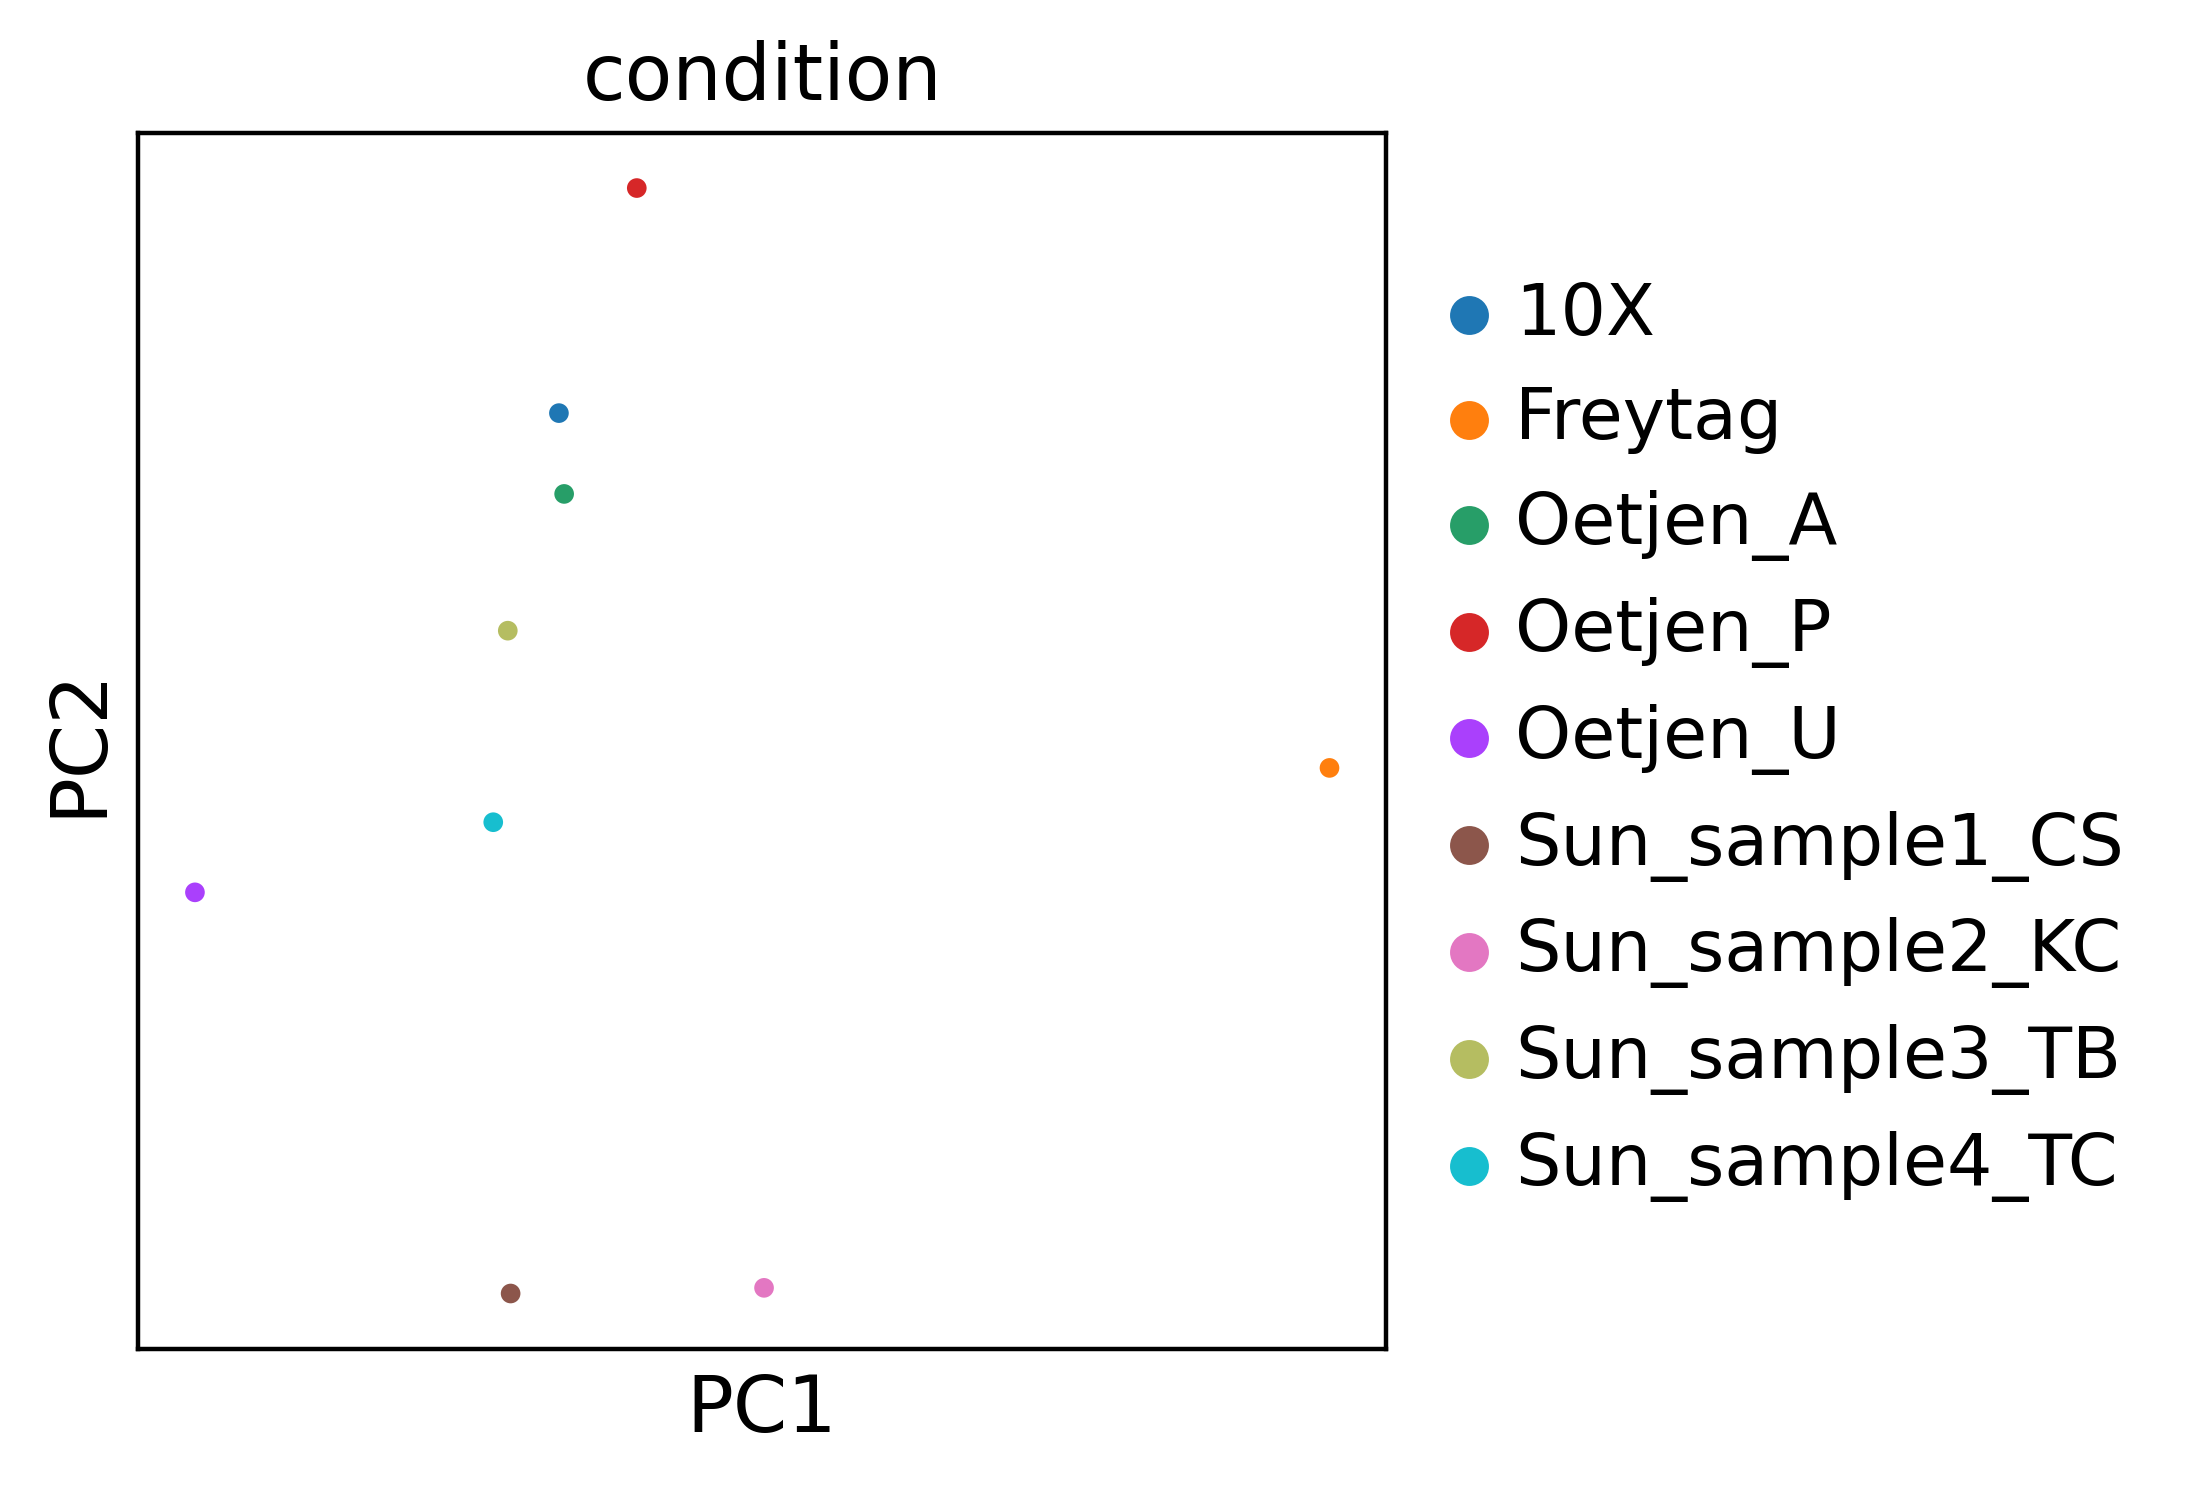

In [128]:
embedding_dec = embed_dec_query.model.embedding.weight.detach().cpu().numpy()
embedding_dec_adata = sc.AnnData(embedding_dec)
sc.pp.pca(embedding_dec_adata)
embedding_dec_adata.obs['condition'] = (
    adata_ref.obs['condition'].unique().tolist()
    + adata_query.obs['condition'].unique().tolist()
)
embedding_dec_adata.obs['condition'] = embedding_dec_adata.obs['condition'].astype('category')
sc.pl.pca(embedding_dec_adata, size=50, color='condition')

[{'preds': array(['CD16+ Monocytes', 'CD4+ T cells', 'CD14+ Monocytes',
       'CD14+ Monocytes', 'NKT cells', 'CD14+ Monocytes',
       'Monocyte progenitors', ..., 'NKT cells', 'NK cells',
       'CD14+ Monocytes', 'CD14+ Monocytes', 'NK cells', 'NK cells',
       'CD4+ T cells'], dtype='<U32'), 'probs': array([0.1 , 0.1 , 0.09, 0.09, 0.09, 0.09, 0.08, ..., 0.09, 0.1 , 0.11,
       0.11, 0.09, 0.1 , 0.11], dtype=float32)}]


... storing 'batch' as categorical


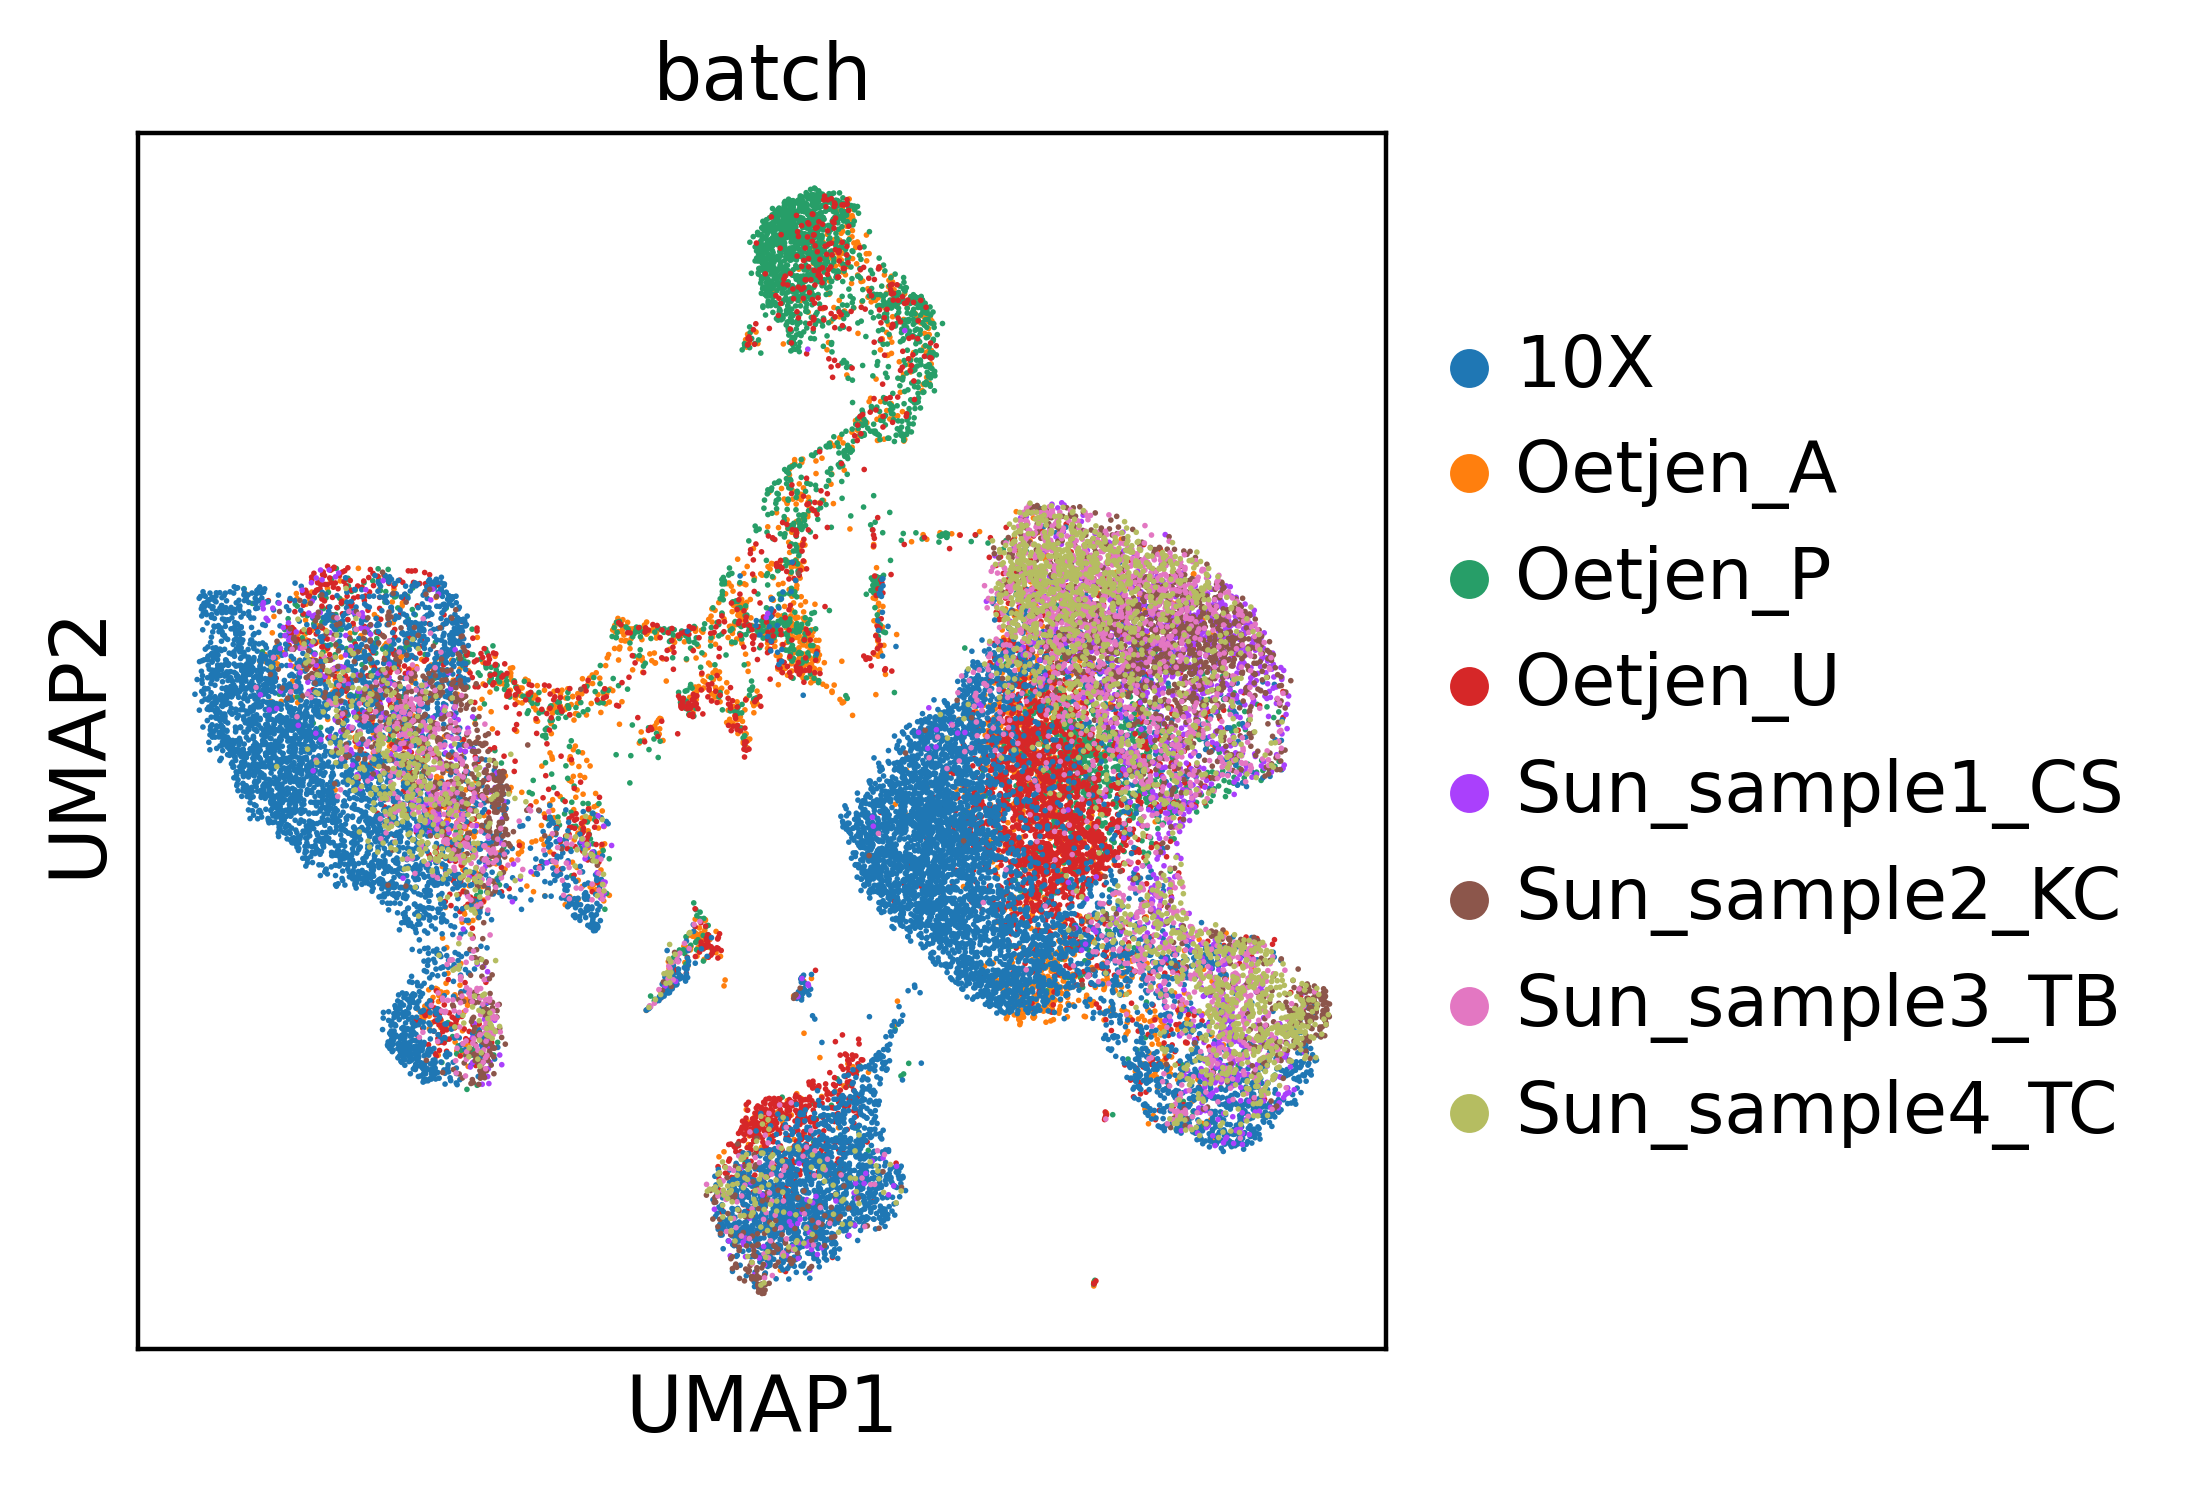

In [133]:
data_latent = embed_dec_query.get_latent(
    adata_ref.X.A, 
    adata_ref.obs[condition_key].values
)
adata_latent_embed_ctrl = sc.AnnData(data_latent)
adata_latent_embed_ctrl.obs['batch'] = adata_ref.obs[condition_key].tolist()
results_dict_embed_ctrl = embed_ctrl.classify(
    adata_ref.X.A, 
    adata_ref.obs[condition_key], 
    metric=class_metric
)
print(results_dict_embed_ctrl)
sc.pp.neighbors(adata_latent_embed_ctrl)
sc.tl.umap(adata_latent_embed_ctrl)
sc.pl.umap(adata_latent_embed_ctrl, color='batch')

[{'preds': array(['CD8+ T cells', 'CD4+ T cells', 'NK cells', 'CD4+ T cells',
       'CD4+ T cells', 'NKT cells', 'CD8+ T cells', ..., 'CD8+ T cells',
       'CD14+ Monocytes', 'Erythrocytes', 'NKT cells', 'CD14+ Monocytes',
       'CD8+ T cells', 'CD20+ B cells'], dtype='<U32'), 'probs': array([0.09, 0.09, 0.08, 0.1 , 0.1 , 0.08, 0.09, ..., 0.09, 0.11, 0.1 ,
       0.08, 0.11, 0.09, 0.09], dtype=float32)}]


... storing 'batch' as categorical


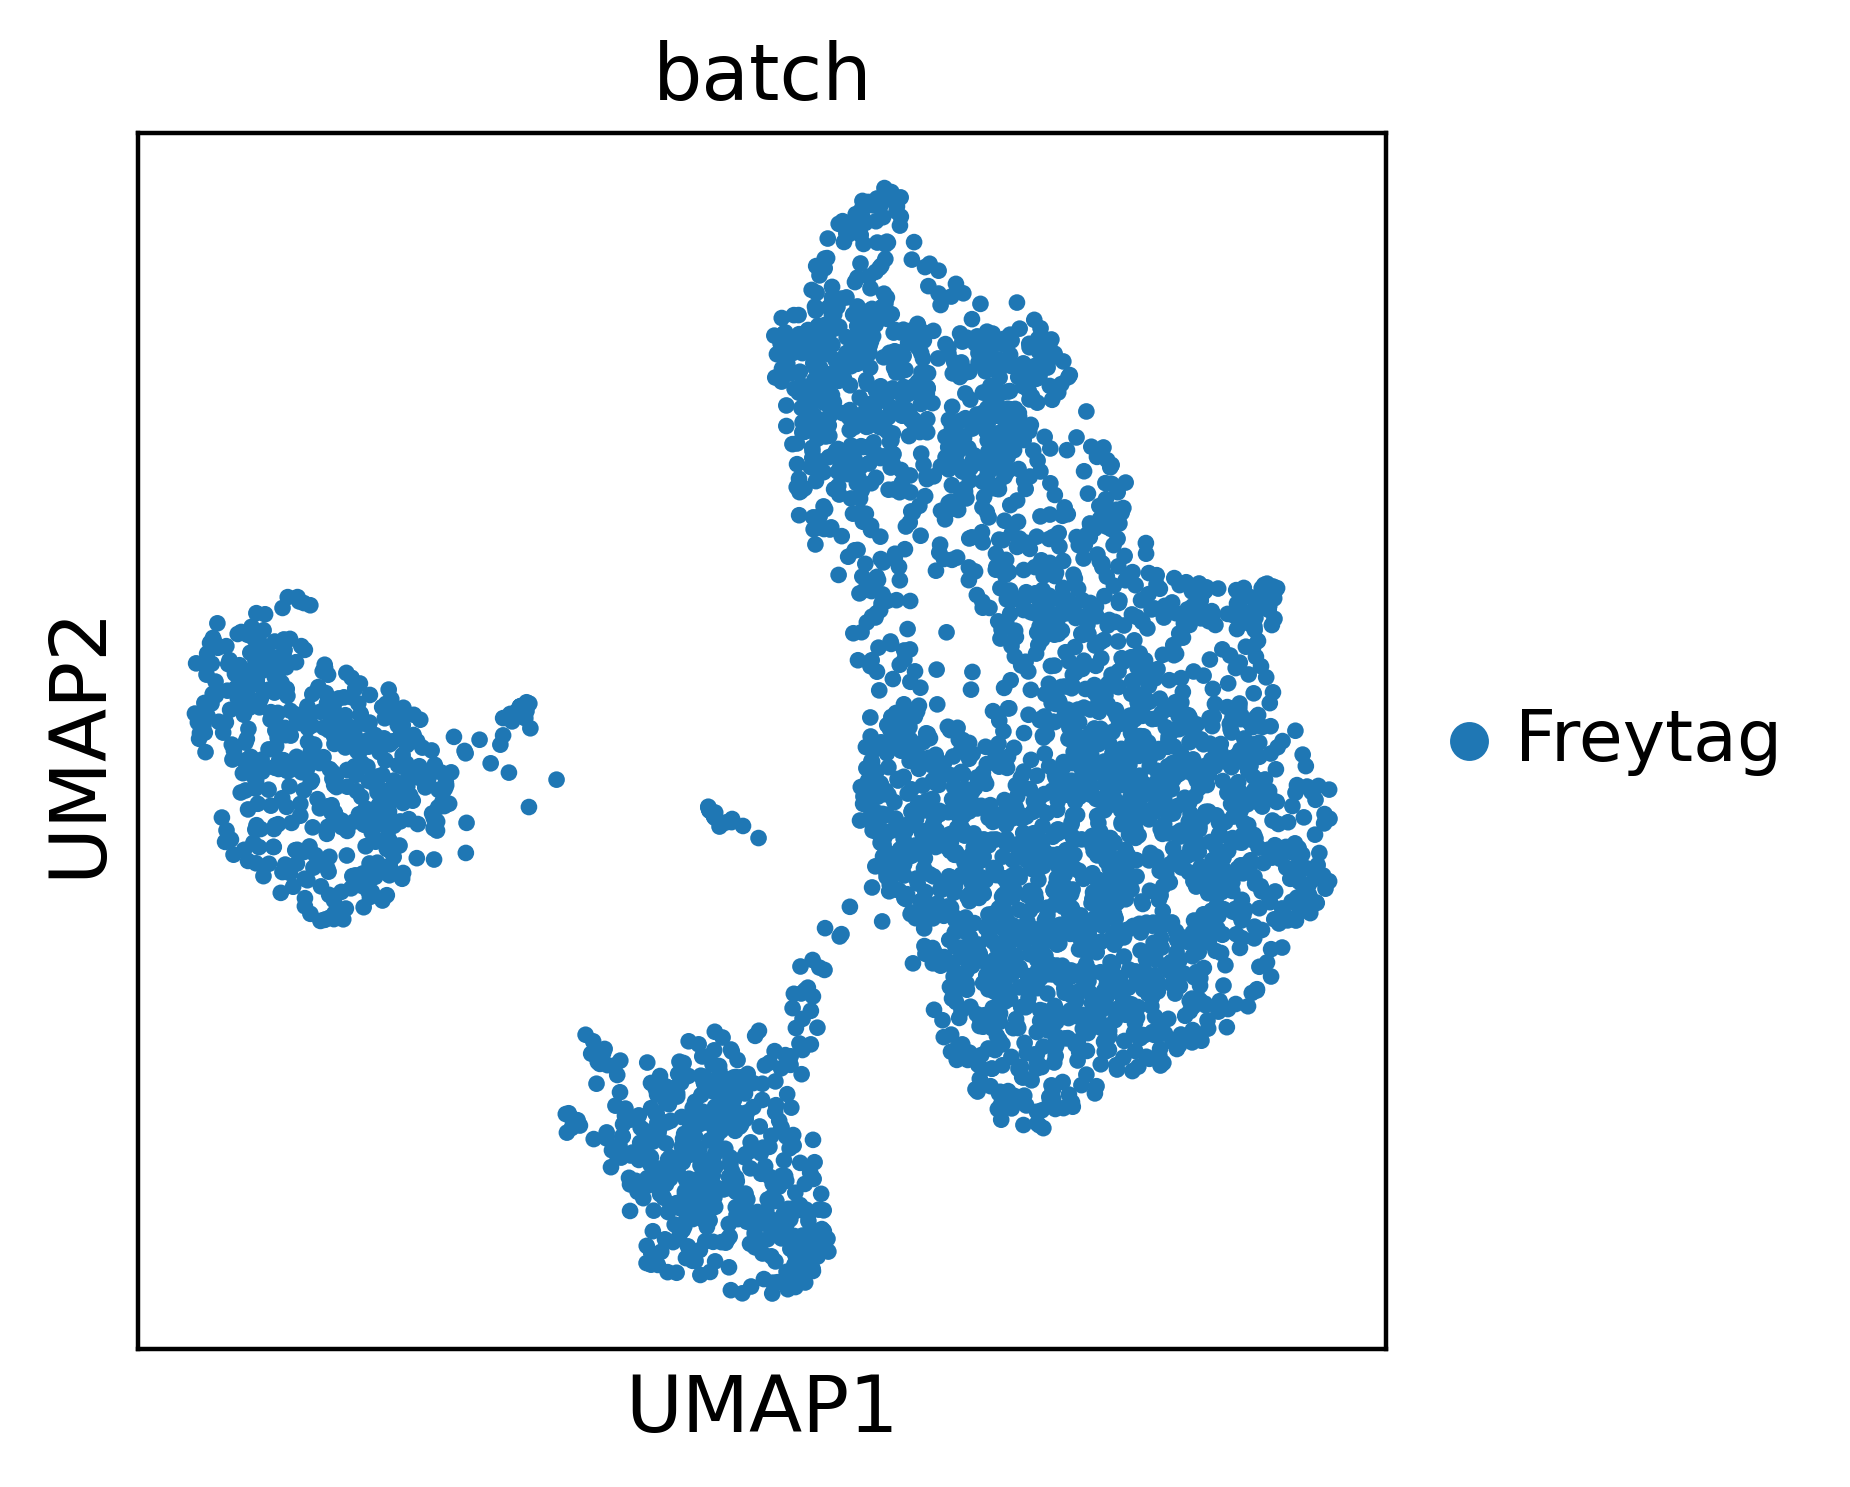

In [135]:
data_latent = embed_dec_query.get_latent(
    adata_query.X.A, 
    adata_query.obs[condition_key].values
)
adata_latent_embed_ctrl = sc.AnnData(data_latent)
adata_latent_embed_ctrl.obs['batch'] = adata_query.obs[condition_key].tolist()
results_dict_embed_ctrl = embed_ctrl.classify(
    adata_query.X.A, 
    adata_query.obs[condition_key], 
    metric=class_metric
)
print(results_dict_embed_ctrl)
sc.pp.neighbors(adata_latent_embed_ctrl)
sc.tl.umap(adata_latent_embed_ctrl)
sc.pl.umap(adata_latent_embed_ctrl, color='batch')

[{'preds': array(['CD16+ Monocytes', 'CD4+ T cells', 'CD14+ Monocytes',
       'CD14+ Monocytes', 'NKT cells', 'CD14+ Monocytes',
       'CD14+ Monocytes', ..., 'NKT cells', 'NK cells', 'CD14+ Monocytes',
       'CD14+ Monocytes', 'NK cells', 'NK cells', 'CD4+ T cells'],
      dtype='<U32'), 'probs': array([0.1 , 0.1 , 0.09, 0.09, 0.09, 0.09, 0.08, ..., 0.09, 0.09, 0.11,
       0.11, 0.09, 0.09, 0.11], dtype=float32)}]


... storing 'batch' as categorical


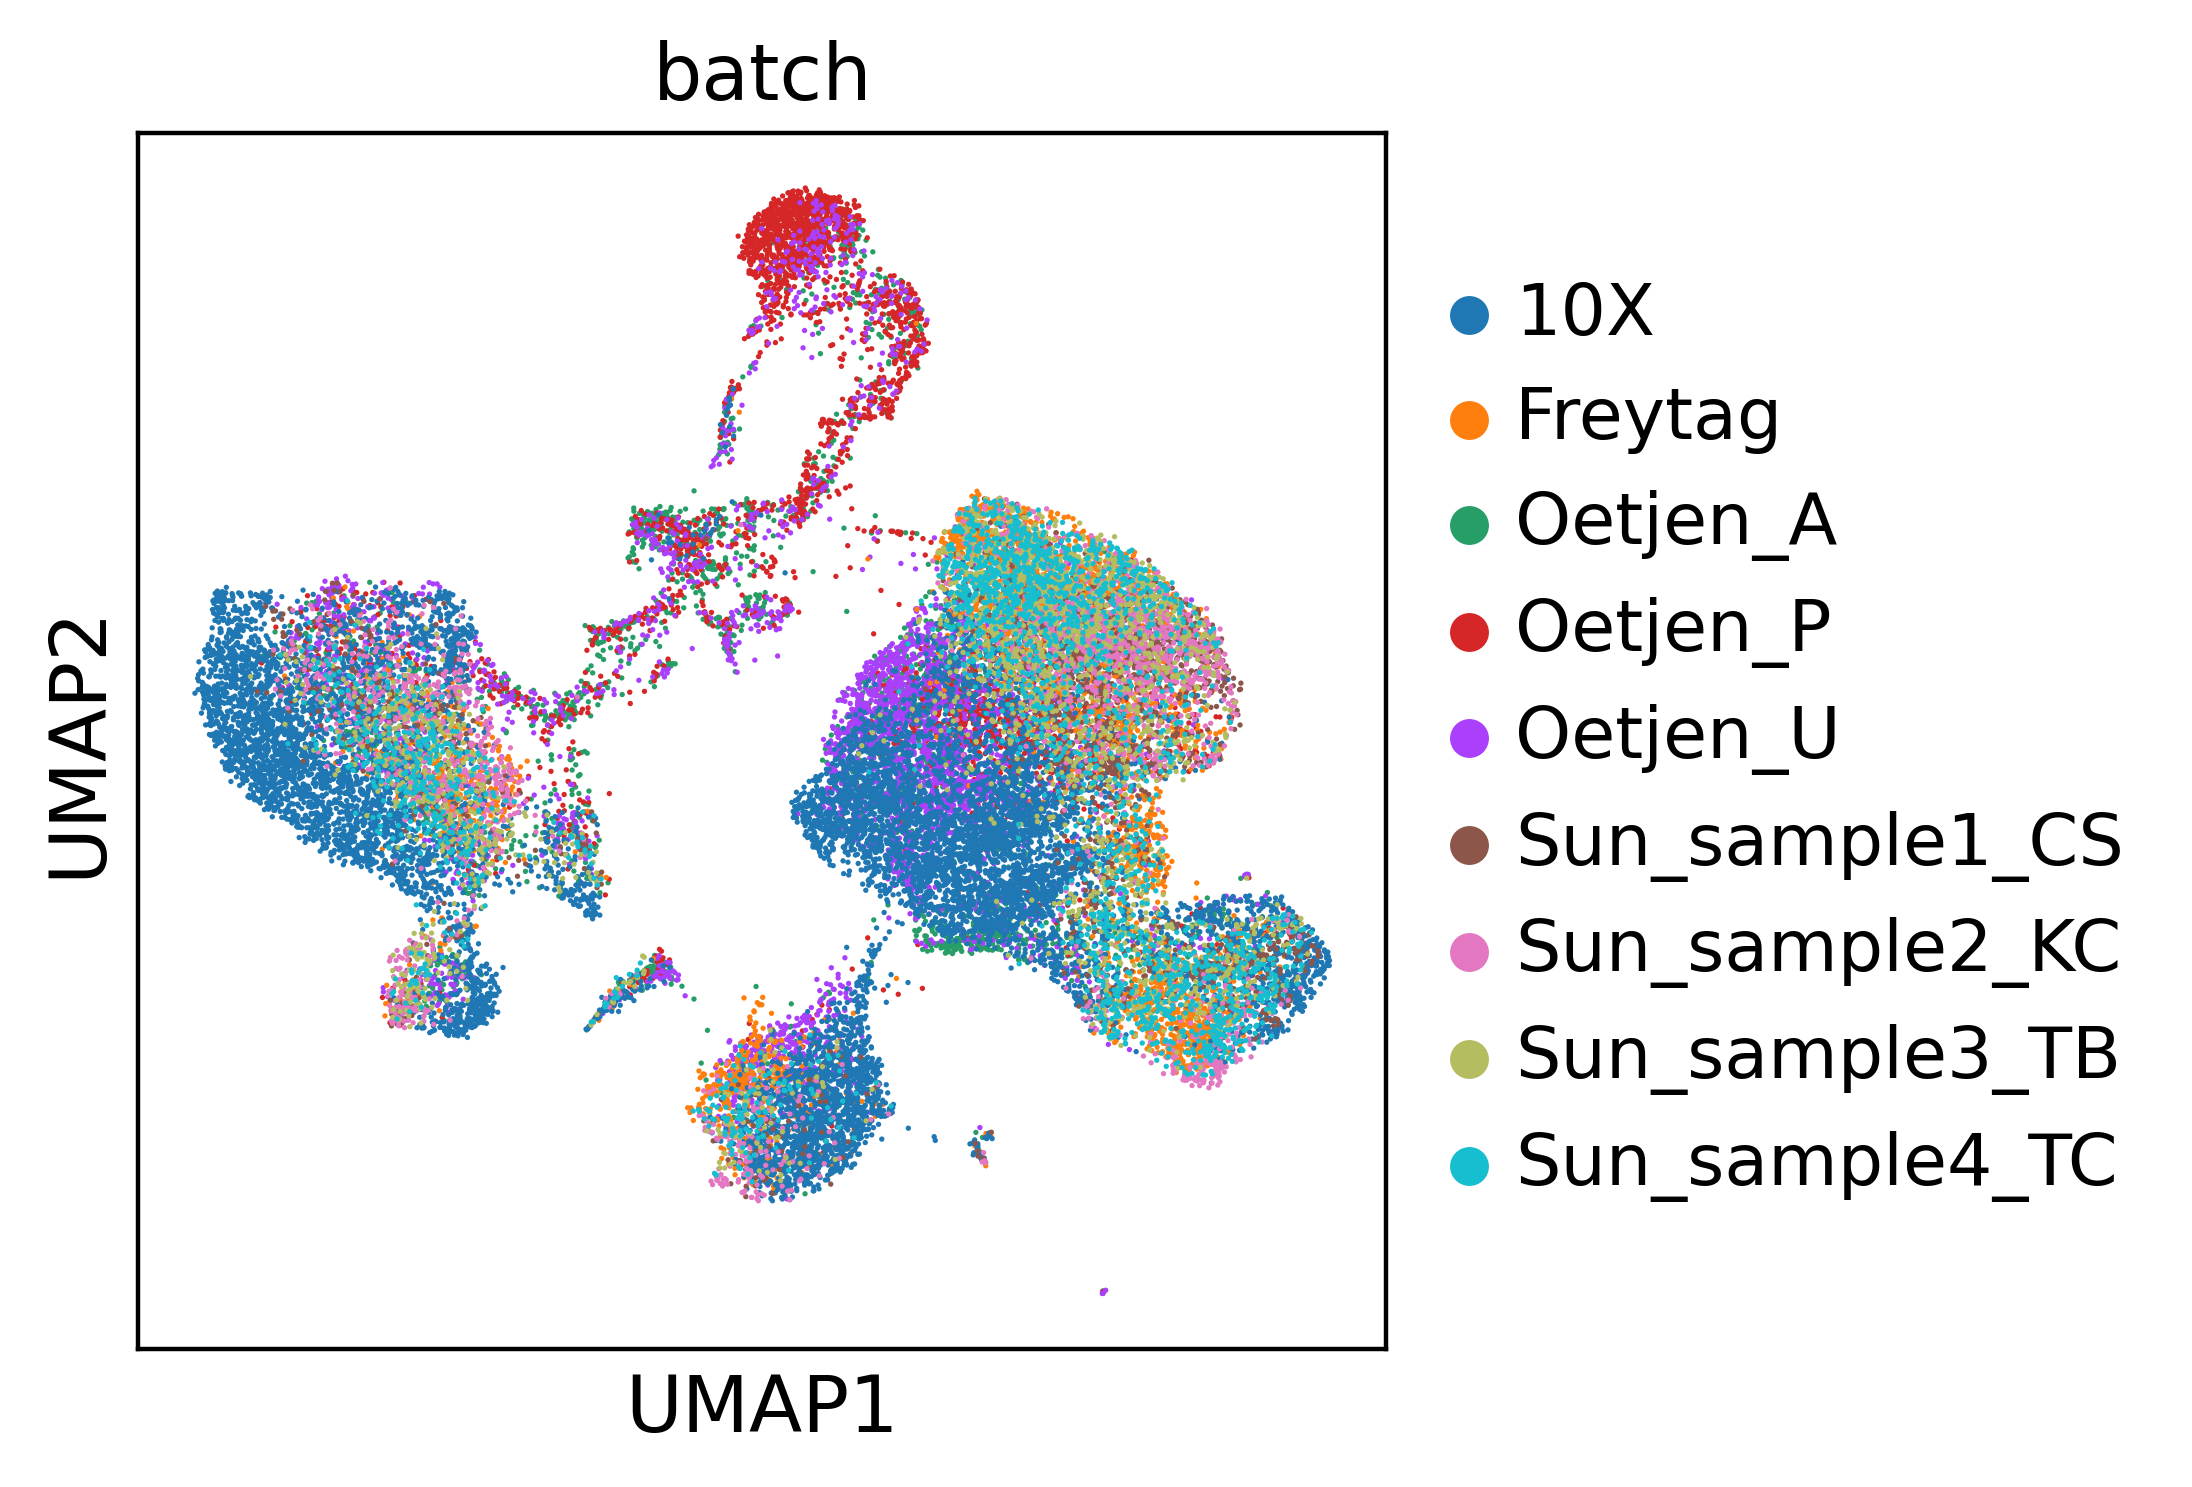

In [136]:
data_latent = embed_dec_query.get_latent(
    adata.X.A, 
    adata.obs[condition_key].values
)
adata_latent_embed_ctrl = sc.AnnData(data_latent)
adata_latent_embed_ctrl.obs['batch'] = adata.obs[condition_key].tolist()
results_dict_embed_ctrl = embed_ctrl.classify(
    adata.X.A, 
    adata.obs[condition_key], 
    metric=class_metric
)
print(results_dict_embed_ctrl)
sc.pp.neighbors(adata_latent_embed_ctrl)
sc.tl.umap(adata_latent_embed_ctrl)
sc.pl.umap(adata_latent_embed_ctrl, color='batch')